In [18]:
import dask.dataframe as dd

In [19]:
import os
try:
    import pycaret
    import pyspark
except:
    os.system("pip install -q pycaret")
    os.system('pip install -q pyspark')
    os.system('pip install -q graphviz')
    os.system('pip install -q dtreeviz')
    os.system("pip install -q pydot")
    os.system("pip install -q autoimpute")
    os.system("pip install -q ydata-profiling")
    pass

In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rakamin-idx/LCDataDictionary.xlsx
/kaggle/input/rakamin-idx/loan_data_2007_2014.csv


# Add Function

In [21]:
import seaborn as sns

def plot_feature_importance(model, feature_names, figsize=(8, 6), orientation='horizontal', ascending=False, n=None):
    feat_importances = pd.Series(model.feature_importances_, index=feature_names)
    if n is None:
        n = len(feat_importances)
    if(ascending):
        feat_importances.sort_values().nlargest(n).plot(kind='barh', figsize=figsize, orientation=orientation)
    else:
        feat_importances.sort_values().nsmallest(n).plot(kind='barh', figsize=figsize, orientation=orientation)
    plt.show()

In [22]:
import pandas as pd

def extract_datetime(df, columns=None, year=True, month=True, day=True, hour=True, minute=True, second=True, drop=False):
    if columns is None:
        columns = df.columns

    for column_name in columns:
        if df[column_name].dtype == 'object':
            try:
                df[column_name] = pd.to_datetime(df[column_name])
            except ValueError:
                pass

        if df[column_name].dtype == 'datetime64[ns]':
            if year:
                df[column_name + '_year'] = df[column_name].dt.year
            if month:
                df[column_name + '_month'] = df[column_name].dt.month
            if day:
                df[column_name + '_day'] = df[column_name].dt.day
            if hour:
                df[column_name + '_hour'] = df[column_name].dt.hour
            if minute:
                df[column_name + '_minute'] = df[column_name].dt.minute
            if second:
                df[column_name + '_second'] = df[column_name].dt.second

            if drop:
                df.drop(column_name, axis=1, inplace=True)

    return df


In [23]:
import re

def tree_to_dot(tree_str, feature_names=None):
    dot_str = 'digraph Tree {\nnode [shape=box] ;\n'
    lines = tree_str.split('\n')
    stack = []
    node_id = 0
    for line in lines:
        if line.strip() == '':
            continue
        depth = len(re.findall('\s\s', line))
        line = line.strip()
        if 'If' in line:
            if ' <= ' in line:
                feature, value = re.findall(r'\(([^)]+)\)', line)[0].split(' <= ')
                feature_name = feature_names[int(feature)] if feature_names else f'X[{feature}]'
                dot_str += f'{node_id} [label="{feature_name} <= {value}"] ;\n'
            elif ' > ' in line:
                feature, value = re.findall(r'\(([^)]+)\)', line)[0].split(' > ')
                feature_name = feature_names[int(feature)] if feature_names else f'X[{feature}]'
                dot_str += f'{node_id} [label="{feature_name} > {value}"] ;\n'
            elif ' in ' in line:
                feature, value = re.findall(r'\(([^)]+)\)', line)[0].split(' in ')
                feature_name = feature_names[int(feature)] if feature_names else f'X[{feature}]'
                dot_str += f'{node_id} [label="{feature_name} in {value}"] ;\n'
            elif ' not in ' in line:
                feature, value = re.findall(r'\(([^)]+)\)', line)[0].split(' not in ')
                feature_name = feature_names[int(feature)] if feature_names else f'X[{feature}]'
                dot_str += f'{node_id} [label="{feature_name} not in {value}"] ;\n'
            if len(stack) > 0:
                dot_str += f'{stack[-1]} -> {node_id} [labeldistance=2.5, labelangle=45, headlabel="True"];\n'
            stack.append(node_id)
            node_id += 1
        elif 'Predict' in line:
            value = re.findall(r': ([^ ]+)', line)[0]
            dot_str += f'{node_id} [label="Predict: {value}", fillcolor="#e5813900"] ;\n'
            dot_str += f'{stack[-1]} -> {node_id} ;\n'
            node_id += 1
        elif 'Else' in line:
            stack = stack[:depth]
            if ' > ' in line:
                feature, value = re.findall(r'\(([^)]+)\)', line)[0].split(' > ')
                feature_name = feature_names[int(feature)] if feature_names else f'X[{feature}]'
                dot_str += f'{node_id} [label="{feature_name} > {value}"] ;\n'
            elif ' <= ' in line:
                feature, value = re.findall(r'\(([^)]+)\)', line)[0].split(' <= ')
                feature_name = feature_names[int(feature)] if feature_names else f'X[{feature}]'
                dot_str += f'{node_id} [label="{feature_name} <= {value}"] ;\n'
            elif ' not in ' in line:
                feature, value = re.findall(r'\(([^)]+)\)', line)[0].split(' not in ')
                feature_name = feature_names[int(feature)] if feature_names else f'X[{feature}]'
                dot_str += f'{node_id} [label="{feature_name} not in {value}"] ;\n'
            elif ' in ' in line:
                feature, value = re.findall(r'\(([^)]+)\)', line)[0].split(' in ')
                feature_name = feature_names[int(feature)] if feature_names else f'X[{feature}]'
                dot_str += f'{node_id} [label="{feature_name} in {value}"] ;\n'
            dot_str += f'{stack[-1]} -> {node_id} [labeldistance=2.5, labelangle=-45, headlabel="False"];\n'
            stack.append(node_id)
            node_id += 1
    dot_str += '}'
    return dot_str

In [24]:
from pyspark.ml.classification import DecisionTreeClassificationModel
# from pyspark.ml.tree import Node

def extract_rules(node, feature_names, rule_string=""):
    if node.numChildren() == 0:
        return rule_string + "Predict: " + str(node.prediction())

    feature = node.split().featureIndex()
    threshold = node.split().threshold()
    feature_name = feature_names[feature]
    condition = " <= " if node.split().leftSide() else " > "
    rule_string += "If (" + feature_name + condition + str(threshold) + ")\n"

    left_child_rule = extract_rules(node.leftChild(), feature_names, rule_string + "  ")
    right_child_rule = extract_rules(node.rightChild(), feature_names, rule_string + "  ")
    return left_child_rule + "\n" + right_child_rule

def decision_tree_to_dot_data(dt_model, feature_names):
    tree_model = dt_model.stages[-1]
    root_node = tree_model._call_java("rootNode")

    dot_data = "digraph Tree {\n"
    dot_data += "node [shape=box]\n"

    rules = extract_rules(root_node, feature_names)
    dot_data += rules

    dot_data += "}"
    return dot_data

In [25]:
import pandas as pd
import scipy.stats as stats
import numpy as np

def cramers_v(df):
    result = pd.DataFrame(index=df.columns, columns=df.columns)
    for col1 in df.columns:
        for col2 in df.columns:
            if col1 != col2:
                contingency_table = pd.crosstab(df[col1], df[col2])
                X2 = stats.chi2_contingency(contingency_table, correction=False)[0]
                n = np.sum(contingency_table.to_numpy())
                minDim = min(contingency_table.shape)-1
                V = np.sqrt((X2/n) / minDim)
                result.loc[col1, col2] = V
    return result

In [26]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif_numeric(df):
    # calculate VIF for each predictor variable
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]

    return vif_data

def calculate_vif_categorical(df,verbose=0):
    # create dummy variables for categorical variables
    df_dummies = pd.get_dummies(df, drop_first=True)
    if(verbose!=0):
        print(df_dummies.dtypes)
    # calculate VIF for each predictor variable
    vif_data = pd.DataFrame()
    vif_data["feature"] = df_dummies.columns
    vif_data["VIF"] = [variance_inflation_factor(df_dummies.values, i) for i in range(len(df_dummies.columns))]

    return vif_data

In [27]:
from pyspark.sql.functions import col

def selectByTypePyspark(colType, df):
    cols = [field.name for field in df.schema.fields if field.dataType == colType]
    return df.select(*cols)

In [28]:
def deselectByTypePyspark(colType, df):
    cols = [field.name for field in df.schema.fields if field.dataType != colType]
    return df.select(*cols)

In [29]:
import re

def parse_tree_string(tree_string):
    # Split the tree string into lines
    lines = tree_string.split('\n')
    
    # Initialize variables
    nodes = []
    stack = []
    
    # Iterate over the lines
    for line in lines:
        # Skip the first line
        if line.startswith('DecisionTreeClassificationModel'):
            continue
        
        # Find the depth of the current node
        depth = line.find('If')
        
        # Check if the line represents a decision node
        if depth >= 0:
            # Find the feature and threshold of the current node
            feature, threshold = re.findall(r'feature (\d+) <= ([\d.]+)', line)[0]
            
            # Create a new node
            node = {'feature': int(feature), 'threshold': float(threshold), 'left': None, 'right': None}
        else:
            # Find the prediction of the current node
            prediction = re.findall(r'Predict: ([\d.]+)', line)[0]
            
            # Create a new node
            node = {'prediction': float(prediction)}
            
            # Set the depth of the current node
            depth = len(stack) - 1
        
        # Add the node to the list of nodes
        nodes.append(node)
        
        # Update the stack
        while len(stack) > depth:
            stack.pop()
        
        # Update the parent node
        if len(stack) > 0:
            parent_node = nodes[stack[-1]]
            if parent_node['left'] is None:
                parent_node['left'] = len(nodes) - 1
            else:
                parent_node['right'] = len(nodes) - 1
        
        # Add the current node to the stack
        stack.append(len(nodes) - 1)
    
    # Return the root node
    return nodes[0]


In [30]:
from graphviz import Digraph

def plot_tree(node, graph=None, parent=None, edge_label=None):
    # Create a new graph
    if graph is None:
        graph = Digraph()
    
    # Get the node ID
    node_id = str(id(node))
    
    # Add the node to the graph
    if 'prediction' in node:
        graph.node(node_id, label=str(node['prediction']))
    else:
        graph.node(node_id, label=f'X[{node["feature"]}] <= {node["threshold"]}')
    
    # Add the edge to the graph
    if parent is not None:
        graph.edge(parent, node_id, label=edge_label)
    
    # Recursively plot the child nodes
    if 'left' in node:
        plot_tree(node['left'], graph=graph, parent=node_id, edge_label='True')
    if 'right' in node:
        plot_tree(node['right'], graph=graph, parent=node_id, edge_label='False')
    
    # Return the graph
    return graph

# Input Data

In [31]:
loan_df = pd.read_csv('/kaggle/input/rakamin-idx/loan_data_2007_2014.csv',low_memory=False)
loan_df.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
from ydata_profiling import ProfileReport
profile = ProfileReport(loan_df, title="Profiling Report")
profile.to_file("your_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Cleaning

In [33]:
print(loan_df.iloc[:,:50].dtypes)

Unnamed: 0                   int64
id                           int64
member_id                    int64
loan_amnt                    int64
funded_amnt                  int64
funded_amnt_inv            float64
term                        object
int_rate                   float64
installment                float64
grade                       object
sub_grade                   object
emp_title                   object
emp_length                  object
home_ownership              object
annual_inc                 float64
verification_status         object
issue_d                     object
loan_status                 object
pymnt_plan                  object
url                         object
desc                        object
purpose                     object
title                       object
zip_code                    object
addr_state                  object
dti                        float64
delinq_2yrs                float64
earliest_cr_line            object
inq_last_6mths      

In [34]:
print(loan_df.iloc[:,50:].dtypes)

collections_12_mths_ex_med     float64
mths_since_last_major_derog    float64
policy_code                      int64
application_type                object
annual_inc_joint               float64
dti_joint                      float64
verification_status_joint      float64
acc_now_delinq                 float64
tot_coll_amt                   float64
tot_cur_bal                    float64
open_acc_6m                    float64
open_il_6m                     float64
open_il_12m                    float64
open_il_24m                    float64
mths_since_rcnt_il             float64
total_bal_il                   float64
il_util                        float64
open_rv_12m                    float64
open_rv_24m                    float64
max_bal_bc                     float64
all_util                       float64
total_rev_hi_lim               float64
inq_fi                         float64
total_cu_tl                    float64
inq_last_12m                   float64
dtype: object


In [35]:
missing_value_bar = loan_df.isna().sum()[loan_df.isna().sum()>0] / loan_df.shape[0] * 100 
missing_value_bar = missing_value_bar.sort_values()
missing_value_bar

annual_inc                       0.000858
title                            0.004289
acc_now_delinq                   0.006219
delinq_2yrs                      0.006219
earliest_cr_line                 0.006219
inq_last_6mths                   0.006219
open_acc                         0.006219
pub_rec                          0.006219
total_acc                        0.006219
last_credit_pull_d               0.009007
collections_12_mths_ex_med       0.031097
revol_util                       0.072917
last_pymnt_d                     0.080637
emp_length                       4.505399
emp_title                        5.916553
total_rev_hi_lim                15.071469
tot_coll_amt                    15.071469
tot_cur_bal                     15.071469
next_pymnt_d                    48.728567
mths_since_last_delinq          53.690554
desc                            72.981546
mths_since_last_major_derog     78.773926
mths_since_last_record          86.566585
inq_fi                         100

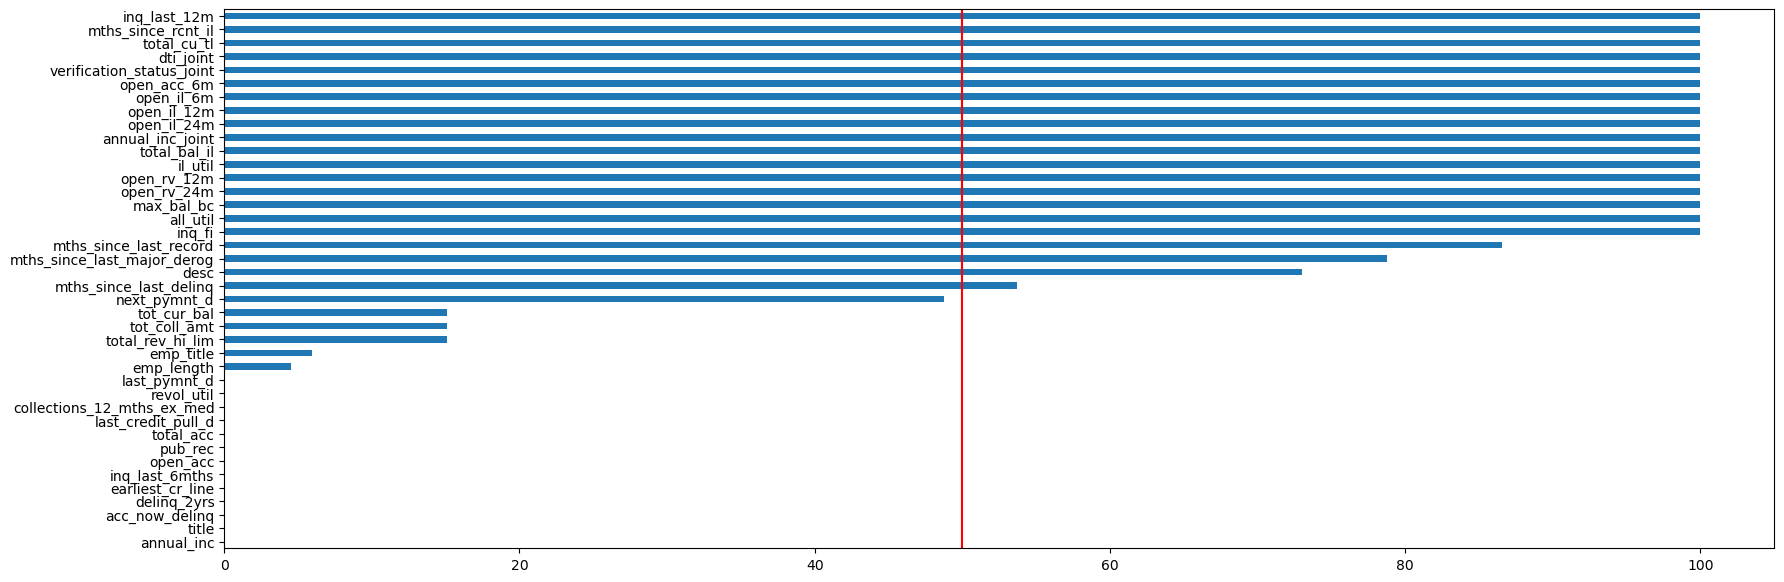

In [36]:
ax = missing_value_bar.plot(kind='barh',figsize=(20,7))
ax.axvline(x=50, color='r')
plt.show()

Minimal 50%
https://www.sciencedirect.com/science/article/pii/S0895435618308710

In [37]:
list_col_miss = missing_value_bar[missing_value_bar>50].index.tolist()
loan_df = loan_df.drop(list_col_miss,axis=1)
loan_df

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,171.62,NaN,Jan-16,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,119.66,NaN,Sep-13,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,649.91,NaN,Jan-16,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,357.48,NaN,Jan-15,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,67.79,Feb-16,Jan-16,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466280,466280,8598660,1440975,18400,18400,18400.0,60 months,14.47,432.64,C,...,432.64,Feb-16,Jan-16,0.0,1,INDIVIDUAL,0.0,0.0,294998.0,29900.0
466281,466281,9684700,11536848,22000,22000,22000.0,60 months,19.97,582.50,D,...,17.50,NaN,Jan-16,0.0,1,INDIVIDUAL,0.0,0.0,221830.0,39400.0
466282,466282,9584776,11436914,20700,20700,20700.0,60 months,16.99,514.34,D,...,514.34,Feb-16,Dec-15,0.0,1,INDIVIDUAL,0.0,0.0,73598.0,13100.0
466283,466283,9604874,11457002,2000,2000,2000.0,36 months,7.90,62.59,A,...,1500.68,NaN,Apr-15,0.0,1,INDIVIDUAL,0.0,0.0,591610.0,53100.0


In [38]:
# reject_stats = ['url',
#  'zip_code',
#  'title',
#  'mths_since_last_record',
#  'mths_since_last_delinq',
#  'issue_d',
#  'inq_last_6mths',
#  'emp_title',
#  'emp_length',
#  'earliest_cr_line',
#  'desc',
#  'addr_state'
# ]

# loan_df = loan_df.drop(reject_stats,axis=1)
# loan_df

In [39]:
loan_df.term.unique()

array([' 36 months', ' 60 months'], dtype=object)

In [40]:
loan_df.term.replace({' 36 months':'36 months',
                      ' 60 months':'60 months'},
                     inplace=True)

In [41]:
loan_df = loan_df.drop("Unnamed: 0",axis=1)
loan_df

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,171.62,NaN,Jan-16,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,119.66,NaN,Sep-13,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,649.91,NaN,Jan-16,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,357.48,NaN,Jan-15,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,...,67.79,Feb-16,Jan-16,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466280,8598660,1440975,18400,18400,18400.0,60 months,14.47,432.64,C,C2,...,432.64,Feb-16,Jan-16,0.0,1,INDIVIDUAL,0.0,0.0,294998.0,29900.0
466281,9684700,11536848,22000,22000,22000.0,60 months,19.97,582.50,D,D5,...,17.50,NaN,Jan-16,0.0,1,INDIVIDUAL,0.0,0.0,221830.0,39400.0
466282,9584776,11436914,20700,20700,20700.0,60 months,16.99,514.34,D,D1,...,514.34,Feb-16,Dec-15,0.0,1,INDIVIDUAL,0.0,0.0,73598.0,13100.0
466283,9604874,11457002,2000,2000,2000.0,36 months,7.90,62.59,A,A4,...,1500.68,NaN,Apr-15,0.0,1,INDIVIDUAL,0.0,0.0,591610.0,53100.0


In [42]:
loan_df = loan_df.drop(['id','member_id'],axis=1)
loan_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,...,171.62,NaN,Jan-16,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN
1,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,...,119.66,NaN,Sep-13,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN
2,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,...,649.91,NaN,Jan-16,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN
3,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,...,357.48,NaN,Jan-15,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN
4,3000,3000,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,...,67.79,Feb-16,Jan-16,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN


# Delete 1 value only

In [43]:
for colname in loan_df.columns:
    banyak = len(loan_df[colname].unique())
    if(banyak==1):
        print(colname,banyak)
loan_df = loan_df.drop(['policy_code','application_type'],axis=1)
loan_df

policy_code 1
application_type 1


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,...,0.00,Jan-15,171.62,NaN,Jan-16,0.0,0.0,NaN,NaN,NaN
1,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,...,1.11,Apr-13,119.66,NaN,Sep-13,0.0,0.0,NaN,NaN,NaN
2,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,...,0.00,Jun-14,649.91,NaN,Jan-16,0.0,0.0,NaN,NaN,NaN
3,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,...,0.00,Jan-15,357.48,NaN,Jan-15,0.0,0.0,NaN,NaN,NaN
4,3000,3000,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,...,0.00,Jan-16,67.79,Feb-16,Jan-16,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466280,18400,18400,18400.0,60 months,14.47,432.64,C,C2,Financial Advisor,4 years,...,0.00,Jan-16,432.64,Feb-16,Jan-16,0.0,0.0,0.0,294998.0,29900.0
466281,22000,22000,22000.0,60 months,19.97,582.50,D,D5,Chief of Interpretation (Park Ranger),10+ years,...,0.00,Dec-14,17.50,NaN,Jan-16,0.0,0.0,0.0,221830.0,39400.0
466282,20700,20700,20700.0,60 months,16.99,514.34,D,D1,patrol,7 years,...,0.00,Jan-16,514.34,Feb-16,Dec-15,0.0,0.0,0.0,73598.0,13100.0
466283,2000,2000,2000.0,36 months,7.90,62.59,A,A4,Server Engineer Lead,3 years,...,0.00,Dec-14,1500.68,NaN,Apr-15,0.0,0.0,0.0,591610.0,53100.0


In [44]:
loan_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,...,0.00,Jan-15,171.62,NaN,Jan-16,0.0,0.0,NaN,NaN,NaN
1,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,...,1.11,Apr-13,119.66,NaN,Sep-13,0.0,0.0,NaN,NaN,NaN
2,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,...,0.00,Jun-14,649.91,NaN,Jan-16,0.0,0.0,NaN,NaN,NaN
3,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,...,0.00,Jan-15,357.48,NaN,Jan-15,0.0,0.0,NaN,NaN,NaN
4,3000,3000,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,...,0.00,Jan-16,67.79,Feb-16,Jan-16,0.0,0.0,NaN,NaN,NaN


In [45]:
loan_df.dtypes

loan_amnt                       int64
funded_amnt                     int64
funded_amnt_inv               float64
term                           object
int_rate                      float64
installment                   float64
grade                          object
sub_grade                      object
emp_title                      object
emp_length                     object
home_ownership                 object
annual_inc                    float64
verification_status            object
issue_d                        object
loan_status                    object
pymnt_plan                     object
url                            object
purpose                        object
title                          object
zip_code                       object
addr_state                     object
dti                           float64
delinq_2yrs                   float64
earliest_cr_line               object
inq_last_6mths                float64
open_acc                      float64
pub_rec     

In [46]:
col_drop_uniq = []
for i in loan_df.select_dtypes(include=['object']).columns:
    print(i)
    print(loan_df[i].unique())
    len_col = len(loan_df[i].unique())
    print(len_col)
    if(len_col>50):
        col_drop_uniq.append(i)
    print()
print(col_drop_uniq)

term
['36 months' '60 months']
2

grade
['B' 'C' 'A' 'E' 'F' 'D' 'G']
7

sub_grade
['B2' 'C4' 'C5' 'C1' 'B5' 'A4' 'E1' 'F2' 'C3' 'B1' 'D1' 'A1' 'B3' 'B4'
 'C2' 'D2' 'A3' 'A5' 'D5' 'A2' 'E4' 'D3' 'D4' 'F3' 'E3' 'F4' 'F1' 'E5'
 'G4' 'E2' 'G3' 'G2' 'G1' 'F5' 'G5']
35

emp_title
[nan 'Ryder' 'AIR RESOURCES BOARD' ... 'MecÃ¡nica'
 'Chief of Interpretation (Park Ranger)' 'Server Engineer Lead']
205476

emp_length
['10+ years' '< 1 year' '1 year' '3 years' '8 years' '9 years' '4 years'
 '5 years' '6 years' '2 years' '7 years' nan]
12

home_ownership
['RENT' 'OWN' 'MORTGAGE' 'OTHER' 'NONE' 'ANY']
6

verification_status
['Verified' 'Source Verified' 'Not Verified']
3

issue_d
['Dec-11' 'Nov-11' 'Oct-11' 'Sep-11' 'Aug-11' 'Jul-11' 'Jun-11' 'May-11'
 'Apr-11' 'Mar-11' 'Feb-11' 'Jan-11' 'Dec-10' 'Nov-10' 'Oct-10' 'Sep-10'
 'Aug-10' 'Jul-10' 'Jun-10' 'May-10' 'Apr-10' 'Mar-10' 'Feb-10' 'Jan-10'
 'Dec-09' 'Nov-09' 'Oct-09' 'Sep-09' 'Aug-09' 'Jul-09' 'Jun-09' 'May-09'
 'Apr-09' 'Mar-09' 'Feb-09' 'Jan

In [47]:
col_drop_uniq = ['emp_title','url','title','zip_code']
col_drop_uniq

['emp_title', 'url', 'title', 'zip_code']

In [48]:
loan_df = loan_df.drop(col_drop_uniq,axis=1)
loan_df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,5000,5000,4975.0,36 months,10.65,162.87,B,B2,10+ years,RENT,...,0.00,Jan-15,171.62,NaN,Jan-16,0.0,0.0,NaN,NaN,NaN
1,2500,2500,2500.0,60 months,15.27,59.83,C,C4,< 1 year,RENT,...,1.11,Apr-13,119.66,NaN,Sep-13,0.0,0.0,NaN,NaN,NaN
2,2400,2400,2400.0,36 months,15.96,84.33,C,C5,10+ years,RENT,...,0.00,Jun-14,649.91,NaN,Jan-16,0.0,0.0,NaN,NaN,NaN
3,10000,10000,10000.0,36 months,13.49,339.31,C,C1,10+ years,RENT,...,0.00,Jan-15,357.48,NaN,Jan-15,0.0,0.0,NaN,NaN,NaN
4,3000,3000,3000.0,60 months,12.69,67.79,B,B5,1 year,RENT,...,0.00,Jan-16,67.79,Feb-16,Jan-16,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466280,18400,18400,18400.0,60 months,14.47,432.64,C,C2,4 years,MORTGAGE,...,0.00,Jan-16,432.64,Feb-16,Jan-16,0.0,0.0,0.0,294998.0,29900.0
466281,22000,22000,22000.0,60 months,19.97,582.50,D,D5,10+ years,MORTGAGE,...,0.00,Dec-14,17.50,NaN,Jan-16,0.0,0.0,0.0,221830.0,39400.0
466282,20700,20700,20700.0,60 months,16.99,514.34,D,D1,7 years,MORTGAGE,...,0.00,Jan-16,514.34,Feb-16,Dec-15,0.0,0.0,0.0,73598.0,13100.0
466283,2000,2000,2000.0,36 months,7.90,62.59,A,A4,3 years,OWN,...,0.00,Dec-14,1500.68,NaN,Apr-15,0.0,0.0,0.0,591610.0,53100.0


In [49]:
loan_df.isna().sum()

loan_amnt                          0
funded_amnt                        0
funded_amnt_inv                    0
term                               0
int_rate                           0
installment                        0
grade                              0
sub_grade                          0
emp_length                     21008
home_ownership                     0
annual_inc                         4
verification_status                0
issue_d                            0
loan_status                        0
pymnt_plan                         0
purpose                            0
addr_state                         0
dti                                0
delinq_2yrs                       29
earliest_cr_line                  29
inq_last_6mths                    29
open_acc                          29
pub_rec                           29
revol_bal                          0
revol_util                       340
total_acc                         29
initial_list_status                0
o

# Imputation

In [50]:
loan_df.last_pymnt_d = pd.to_datetime(loan_df.last_pymnt_d,format="%b-%y")
loan_df.last_credit_pull_d = pd.to_datetime(loan_df.last_credit_pull_d,format="%b-%y")
loan_df.next_pymnt_d = pd.to_datetime(loan_df.next_pymnt_d,format="%b-%y")
loan_df.earliest_cr_line = pd.to_datetime(loan_df.earliest_cr_line,format="%b-%y")
loan_df.issue_d = pd.to_datetime(loan_df.issue_d,format="%b-%y")
loan_df.dtypes

loan_amnt                              int64
funded_amnt                            int64
funded_amnt_inv                      float64
term                                  object
int_rate                             float64
installment                          float64
grade                                 object
sub_grade                             object
emp_length                            object
home_ownership                        object
annual_inc                           float64
verification_status                   object
issue_d                       datetime64[ns]
loan_status                           object
pymnt_plan                            object
purpose                               object
addr_state                            object
dti                                  float64
delinq_2yrs                          float64
earliest_cr_line              datetime64[ns]
inq_last_6mths                       float64
open_acc                             float64
pub_rec   

In [51]:
list_col_date = loan_df.select_dtypes(include=['datetime64']).columns.tolist()
loan_df[list_col_date] = loan_df[list_col_date].interpolate(method='pad',)
loan_df.next_pymnt_d = loan_df.next_pymnt_d.fillna(loan_df.next_pymnt_d.value_counts().index[0])
print(loan_df[list_col_date].isna().sum())

issue_d               0
earliest_cr_line      0
last_pymnt_d          0
next_pymnt_d          0
last_credit_pull_d    0
dtype: int64


In [52]:
loan_df.select_dtypes(include='object')

,term,grade,sub_grade,emp_length,home_ownership,verification_status,loan_status,pymnt_plan,purpose,addr_state,initial_list_status
0,36 months,B,B2,10+ years,RENT,Verified,Fully Paid,n,credit_card,AZ,f
1,60 months,C,C4,< 1 year,RENT,Source Verified,Charged Off,n,car,GA,f
2,36 months,C,C5,10+ years,RENT,Not Verified,Fully Paid,n,small_business,IL,f
3,36 months,C,C1,10+ years,RENT,Source Verified,Fully Paid,n,other,CA,f
4,60 months,B,B5,1 year,RENT,Source Verified,Current,n,other,OR,f
...,...,...,...,...,...,...,...,...,...,...,...
466280,60 months,C,C2,4 years,MORTGAGE,Source Verified,Current,n,debt_consolidation,TX,w
466281,60 months,D,D5,10+ years,MORTGAGE,Verified,Charged Off,n,debt_consolidation,TN,f
466282,60 months,D,D1,7 years,MORTGAGE,Verified,Current,n,debt_consolidation,OH,f
466283,36 months,A,A4,3 years,OWN,Verified,Fully Paid,n,credit_card,CA,w


In [53]:
from statsmodels.imputation.mice import MICEData
loan_df_nondate = loan_df.select_dtypes(exclude=['object','datetime64'])
imp = MICEData(loan_df_nondate)
imp.update_all(5)
loan_df_nondate = imp.data
loan_df[loan_df_nondate.columns.tolist()] = loan_df_nondate
loan_df.emp_length = loan_df.emp_length.fillna(loan_df.emp_length.value_counts().index[0])
loan_df.isna().sum()

loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
grade                         0
sub_grade                     0
emp_length                    0
home_ownership                0
annual_inc                    0
verification_status           0
issue_d                       0
loan_status                   0
pymnt_plan                    0
purpose                       0
addr_state                    0
dti                           0
delinq_2yrs                   0
earliest_cr_line              0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
total_acc                     0
initial_list_status           0
out_prncp                     0
out_prncp_inv                 0
total_pymnt                   0
total_pymnt_inv               0
total_re

In [54]:
from statsmodels.imputation.mice import MICEData
loan_df_num = loan_df.select_dtypes(exclude=['object','datetime64'])
loan_df.isna().sum()

loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
grade                         0
sub_grade                     0
emp_length                    0
home_ownership                0
annual_inc                    0
verification_status           0
issue_d                       0
loan_status                   0
pymnt_plan                    0
purpose                       0
addr_state                    0
dti                           0
delinq_2yrs                   0
earliest_cr_line              0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
total_acc                     0
initial_list_status           0
out_prncp                     0
out_prncp_inv                 0
total_pymnt                   0
total_pymnt_inv               0
total_re

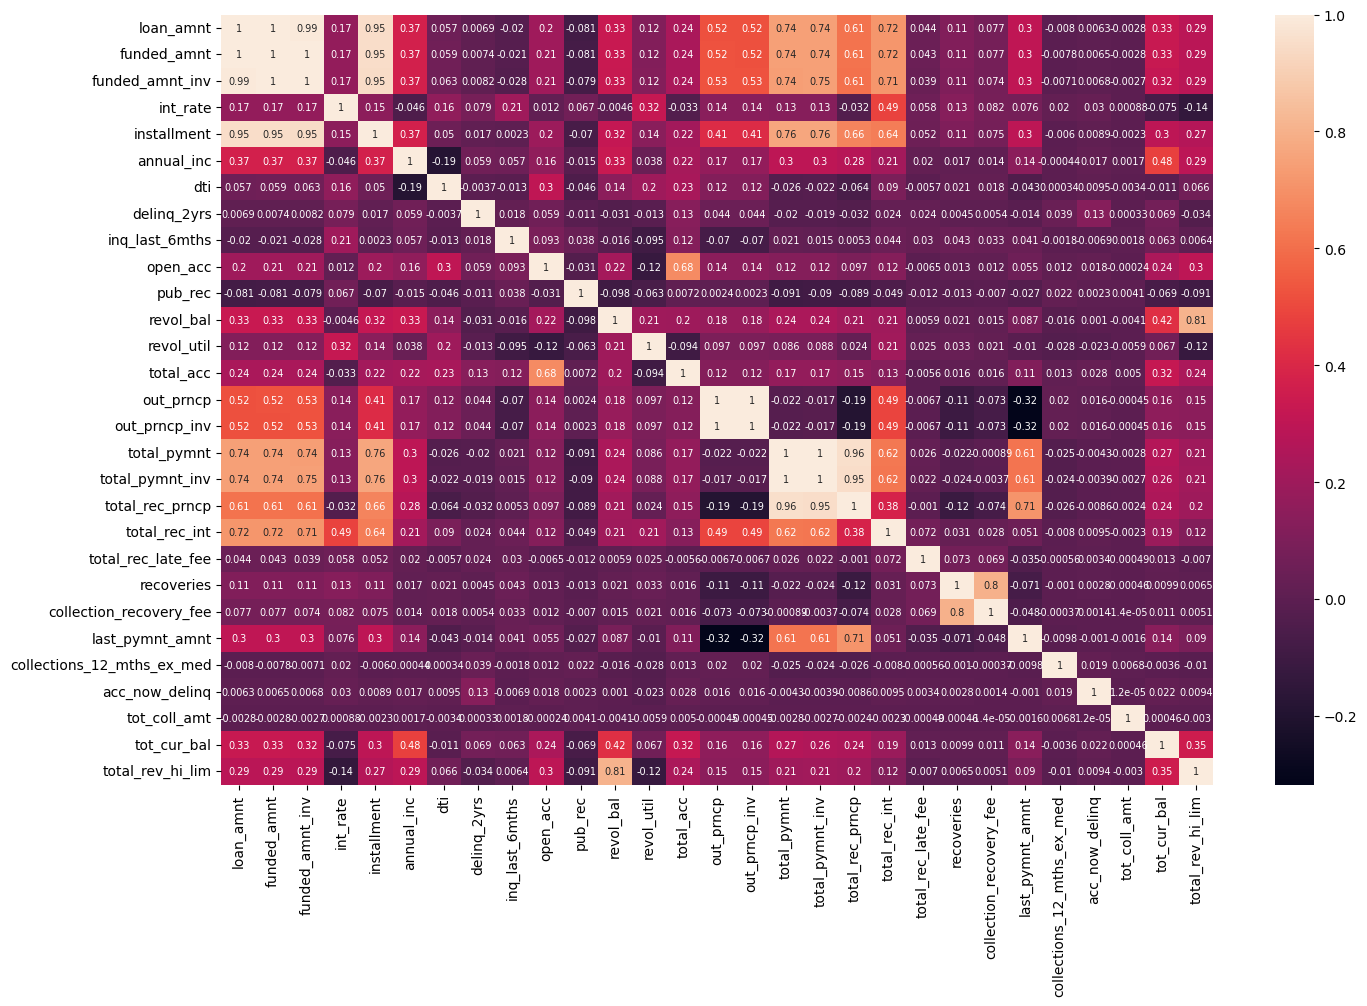

In [55]:
import seaborn as sns
# Resize the heatmap
fig, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(loan_df_num.corr(),
            annot=True,
            ax=ax,
            annot_kws={"fontsize":7},
            
           )

plt.show()

In [56]:
numeric_vif = calculate_vif_numeric(loan_df_num)
numeric_vif = numeric_vif.sort_values('VIF',ascending=False)
numeric_vif

,feature,VIF
16,total_pymnt,1.305391e+14
18,total_rec_prncp,8.263486e+13
19,total_rec_int,8.278676e+12
21,recoveries,2.008608e+11
20,total_rec_late_fee,1.810985e+07
14,out_prncp,4.274016e+05
15,out_prncp_inv,4.273349e+05
1,funded_amnt,4.888667e+03
2,funded_amnt_inv,3.325682e+03
17,total_pymnt_inv,2.334859e+03


In [57]:
drop_vif = ['total_pymnt',
            'out_prncp',
            'funded_amnt',
            'funded_amnt_inv',
            'total_pymnt_inv',
            'loan_amnt',
            'installment',
            'int_rate',
            'open_acc',
            'total_rec_prncp',
            'total_acc',
            'revol_util',
            'revol_bal'
            ]
numeric_vif = calculate_vif_numeric(loan_df_num.drop(drop_vif,
                                                     axis=1
                                                    )
                                   )
numeric_vif = numeric_vif.sort_values('VIF',ascending=False)
numeric_vif

,feature,VIF
0,annual_inc,3.370834
6,total_rec_int,3.032734
8,recoveries,2.921460
9,collection_recovery_fee,2.820769
1,dti,2.787645
14,tot_cur_bal,2.574099
5,out_prncp_inv,2.541033
15,total_rev_hi_lim,2.033817
10,last_pymnt_amnt,1.655054
3,inq_last_6mths,1.518302


Multicollinearity dihilangkan agar akurasi bisa lebih bagus dan juga supaya dapat memperingkas kolom agar komputasi lebih ringan. batas multikolinear adalah 5% . https://quantifyinghealth.com/vif-threshold/

In [58]:
loan_df_num = loan_df_num[numeric_vif.feature.to_list()]
loan_df_num

,annual_inc,total_rec_int,recoveries,collection_recovery_fee,dti,tot_cur_bal,out_prncp_inv,total_rev_hi_lim,last_pymnt_amnt,inq_last_6mths,delinq_2yrs,pub_rec,total_rec_late_fee,acc_now_delinq,collections_12_mths_ex_med,tot_coll_amt
0,24000.0,861.07,0.00,0.00,27.65,20179.0,0.00,10050.0,171.62,1.0,0.0,0.0,0.00,0.0,0.0,0.0
1,30000.0,435.17,117.08,1.11,1.00,34485.0,0.00,24300.0,119.66,5.0,0.0,0.0,0.00,0.0,0.0,0.0
2,12252.0,603.65,0.00,0.00,8.72,15139.0,0.00,3300.0,649.91,2.0,0.0,0.0,0.00,0.0,0.0,0.0
3,49200.0,2209.33,0.00,0.00,20.00,59531.0,0.00,26000.0,357.48,1.0,0.0,0.0,16.97,0.0,0.0,0.0
4,80000.0,1009.07,0.00,0.00,17.94,343673.0,766.90,52800.0,67.79,0.0,0.0,0.0,0.00,0.0,0.0,76.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466280,110000.0,4557.36,0.00,0.00,19.85,294998.0,12574.00,29900.0,432.64,2.0,0.0,0.0,0.00,0.0,0.0,0.0
466281,78000.0,2840.88,0.00,0.00,18.45,221830.0,0.00,39400.0,17.50,5.0,0.0,1.0,0.00,0.0,0.0,0.0
466282,46000.0,6072.29,0.00,0.00,25.65,73598.0,14428.31,13100.0,514.34,2.0,0.0,0.0,0.00,0.0,0.0,0.0
466283,83000.0,126.58,0.00,0.00,5.39,591610.0,0.00,53100.0,1500.68,1.0,3.0,0.0,0.00,0.0,0.0,0.0


In [59]:
loan_df = loan_df.drop(drop_vif,axis=1)
loan_df

,term,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,...,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,36 months,B,B2,10+ years,RENT,24000.0,Verified,2011-12-01,Fully Paid,n,...,0.00,2015-01-01,171.62,2016-02-01,2016-01-01,0.0,0.0,0.0,20179.0,10050.0
1,60 months,C,C4,< 1 year,RENT,30000.0,Source Verified,2011-12-01,Charged Off,n,...,1.11,2013-04-01,119.66,2016-02-01,2013-09-01,0.0,0.0,0.0,34485.0,24300.0
2,36 months,C,C5,10+ years,RENT,12252.0,Not Verified,2011-12-01,Fully Paid,n,...,0.00,2014-06-01,649.91,2016-02-01,2016-01-01,0.0,0.0,0.0,15139.0,3300.0
3,36 months,C,C1,10+ years,RENT,49200.0,Source Verified,2011-12-01,Fully Paid,n,...,0.00,2015-01-01,357.48,2016-02-01,2015-01-01,0.0,0.0,0.0,59531.0,26000.0
4,60 months,B,B5,1 year,RENT,80000.0,Source Verified,2011-12-01,Current,n,...,0.00,2016-01-01,67.79,2016-02-01,2016-01-01,0.0,0.0,76.0,343673.0,52800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466280,60 months,C,C2,4 years,MORTGAGE,110000.0,Source Verified,2014-01-01,Current,n,...,0.00,2016-01-01,432.64,2016-02-01,2016-01-01,0.0,0.0,0.0,294998.0,29900.0
466281,60 months,D,D5,10+ years,MORTGAGE,78000.0,Verified,2014-01-01,Charged Off,n,...,0.00,2014-12-01,17.50,2016-02-01,2016-01-01,0.0,0.0,0.0,221830.0,39400.0
466282,60 months,D,D1,7 years,MORTGAGE,46000.0,Verified,2014-01-01,Current,n,...,0.00,2016-01-01,514.34,2016-02-01,2015-12-01,0.0,0.0,0.0,73598.0,13100.0
466283,36 months,A,A4,3 years,OWN,83000.0,Verified,2014-01-01,Fully Paid,n,...,0.00,2014-12-01,1500.68,2016-02-01,2015-04-01,0.0,0.0,0.0,591610.0,53100.0


<Axes: >

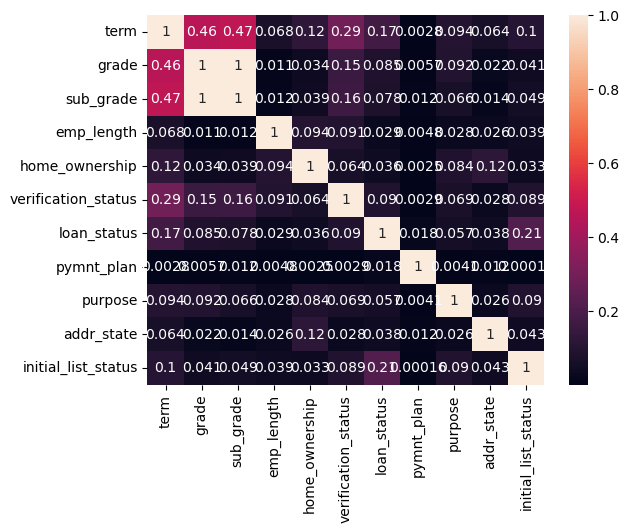

In [60]:
crem_v = cramers_v(loan_df.select_dtypes(include='object'))
crem_v = crem_v.fillna(1)
sns.heatmap(crem_v,annot=True)

In [61]:
loan_df = loan_df.drop(['sub_grade','addr_state'],
                       axis=1
                      )
loan_df

,term,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,...,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,36 months,B,10+ years,RENT,24000.0,Verified,2011-12-01,Fully Paid,n,credit_card,...,0.00,2015-01-01,171.62,2016-02-01,2016-01-01,0.0,0.0,0.0,20179.0,10050.0
1,60 months,C,< 1 year,RENT,30000.0,Source Verified,2011-12-01,Charged Off,n,car,...,1.11,2013-04-01,119.66,2016-02-01,2013-09-01,0.0,0.0,0.0,34485.0,24300.0
2,36 months,C,10+ years,RENT,12252.0,Not Verified,2011-12-01,Fully Paid,n,small_business,...,0.00,2014-06-01,649.91,2016-02-01,2016-01-01,0.0,0.0,0.0,15139.0,3300.0
3,36 months,C,10+ years,RENT,49200.0,Source Verified,2011-12-01,Fully Paid,n,other,...,0.00,2015-01-01,357.48,2016-02-01,2015-01-01,0.0,0.0,0.0,59531.0,26000.0
4,60 months,B,1 year,RENT,80000.0,Source Verified,2011-12-01,Current,n,other,...,0.00,2016-01-01,67.79,2016-02-01,2016-01-01,0.0,0.0,76.0,343673.0,52800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466280,60 months,C,4 years,MORTGAGE,110000.0,Source Verified,2014-01-01,Current,n,debt_consolidation,...,0.00,2016-01-01,432.64,2016-02-01,2016-01-01,0.0,0.0,0.0,294998.0,29900.0
466281,60 months,D,10+ years,MORTGAGE,78000.0,Verified,2014-01-01,Charged Off,n,debt_consolidation,...,0.00,2014-12-01,17.50,2016-02-01,2016-01-01,0.0,0.0,0.0,221830.0,39400.0
466282,60 months,D,7 years,MORTGAGE,46000.0,Verified,2014-01-01,Current,n,debt_consolidation,...,0.00,2016-01-01,514.34,2016-02-01,2015-12-01,0.0,0.0,0.0,73598.0,13100.0
466283,36 months,A,3 years,OWN,83000.0,Verified,2014-01-01,Fully Paid,n,credit_card,...,0.00,2014-12-01,1500.68,2016-02-01,2015-04-01,0.0,0.0,0.0,591610.0,53100.0


In [62]:
# objek_vif = calculate_vif_categorical(loan_df.select_dtypes(include='object').drop(['sub_grade'],axis=1))
objek_vif = calculate_vif_categorical(loan_df.select_dtypes(include='object'))
objek_vif = objek_vif.sort_values('VIF',ascending=False)
objek_vif

,feature,VIF
19,home_ownership_OTHER,1.047683
18,home_ownership_NONE,1.013071
32,pymnt_plan_y,1.000432
35,purpose_educational,0.427483
26,loan_status_Does not meet the credit policy. S...,0.336078
42,purpose_renewable_energy,0.288449
30,loan_status_Late (16-30 days),0.163965
37,purpose_house,0.138714
44,purpose_vacation,0.107902
27,loan_status_Does not meet the credit policy. S...,0.104848


# EDA

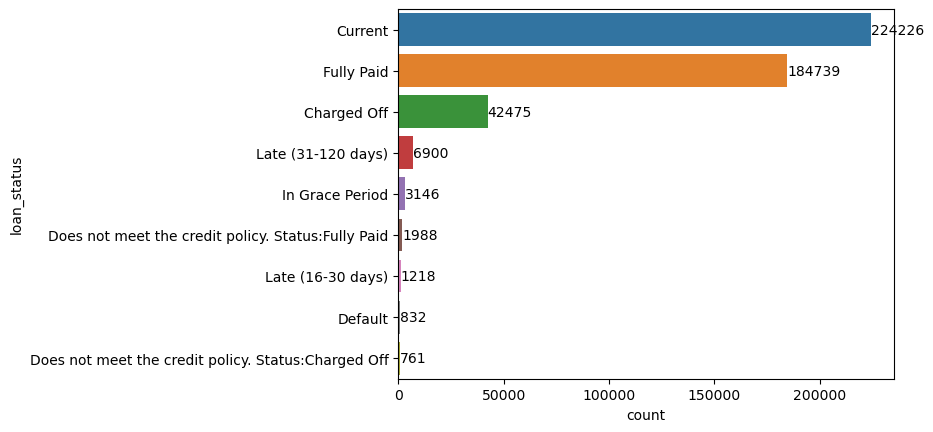

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=loan_df,
              y='loan_status',
              order=loan_df['loan_status'].value_counts().index
             )

# Add annotations to display the count of each category
for p in plt.gca().patches:
    plt.gca().text(p.get_width(), 
                   p.get_y() + p.get_height() / 2.,
                   f'{int(p.get_width())}',
                   va='center',
                  )
# Show the plot
plt.show()

Dari Data ini membuktikan bahwa :
* Disini ada lebih banyak status utang, current ,fully paid, dan chargeoff
* Ada terjadinya ketidakseimbangan antar kelasnya

<Axes: >

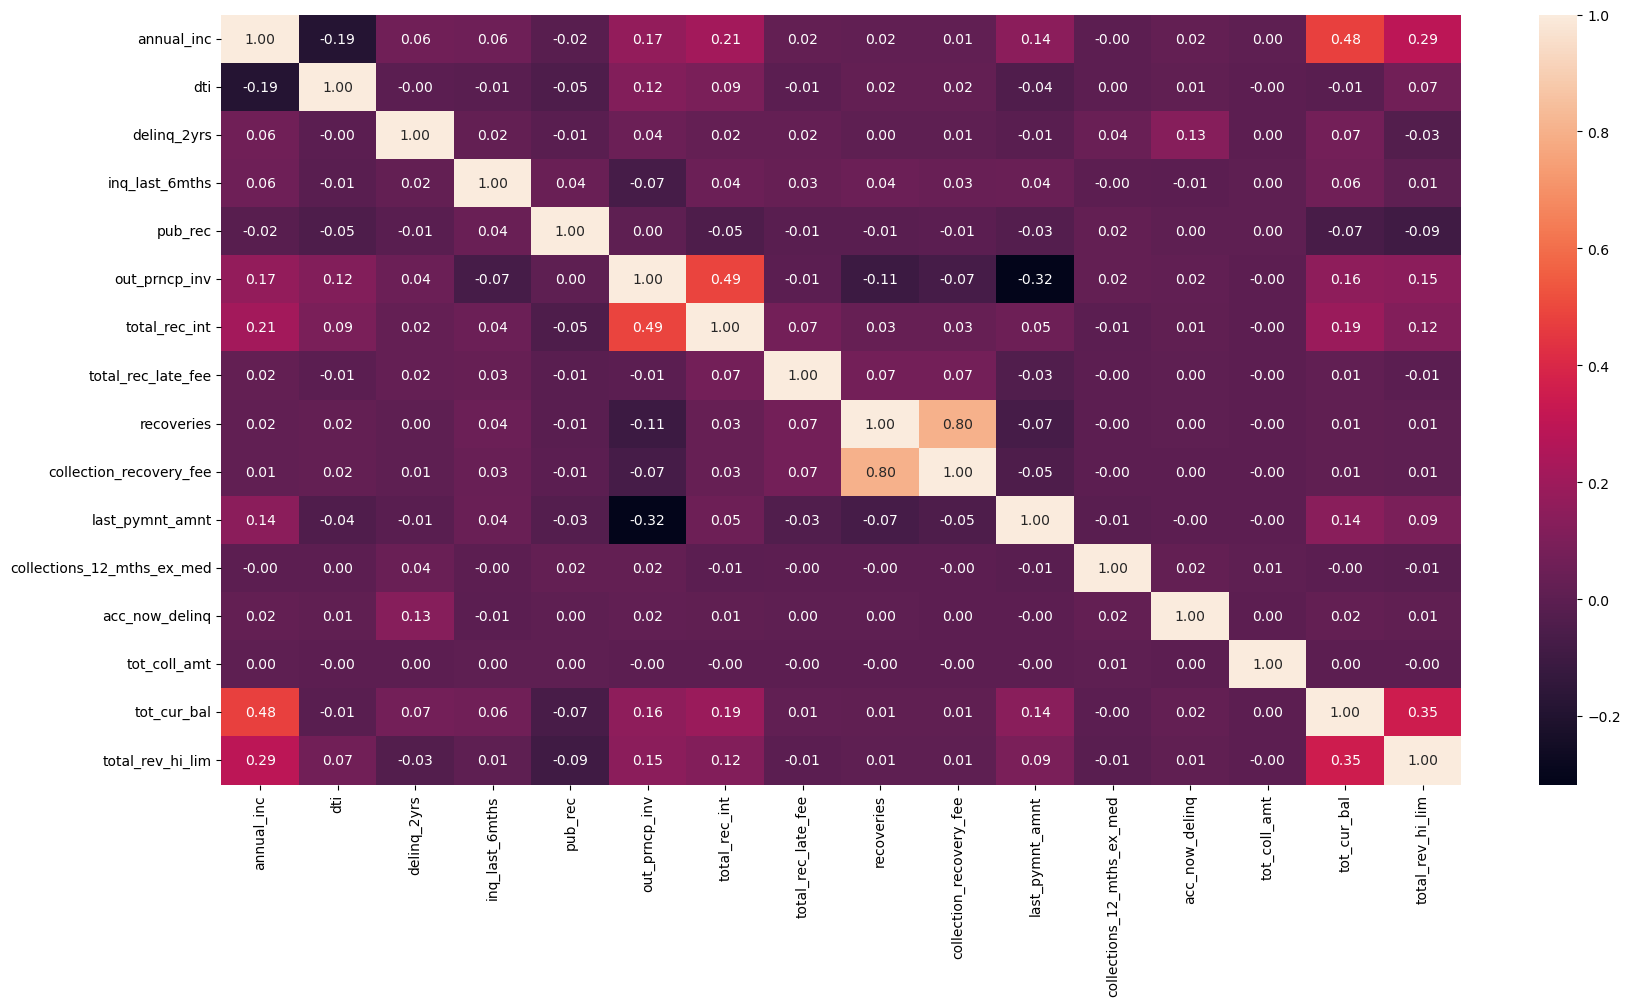

In [64]:
plt.figure(figsize=(20, 10))
sns.heatmap(loan_df.corr(),annot=True,fmt='.2f')

### Korelasi
* kemungkinan autocolinearity antara total_pymnt,total_pymnt_inv, total_rec_prncp
* kemungkinan autocolinearity antara funded_amnt, funded_amnt_inv
* kemungkinan autocolinearity antara installment dengan funded_amnt, funded_amnt_inv, dan loan_amnt
* kemungkinan autocolinearity antara out_prncp dengan out_prncp_inv

# Machine Learning with Sklearn without SMOTE

In [65]:
!pip install -U imbalanced-learn

In [66]:
loan_df_cop = loan_df.copy()
# print(loan_df_cop.select_dtypes(include=['object']).columns)
loan_df_cop = pd.get_dummies(loan_df_cop,columns=['term', 'grade','emp_length',
                                                  'home_ownership', 'verification_status',
                                                  #'loan_status',
                                                  'pymnt_plan','purpose', 'initial_list_status'
                                                 ]
                            )
loan_df_cop

,annual_inc,issue_d,loan_status,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,pub_rec,out_prncp_inv,total_rec_int,...,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_f,initial_list_status_w
0,24000.0,2011-12-01,Fully Paid,27.65,0.0,1985-01-01,1.0,0.0,0.00,861.07,...,0,0,0,0,0,0,0,0,1,0
1,30000.0,2011-12-01,Charged Off,1.00,0.0,1999-04-01,5.0,0.0,0.00,435.17,...,0,0,0,0,0,0,0,0,1,0
2,12252.0,2011-12-01,Fully Paid,8.72,0.0,2001-11-01,2.0,0.0,0.00,603.65,...,0,0,0,0,0,1,0,0,1,0
3,49200.0,2011-12-01,Fully Paid,20.00,0.0,1996-02-01,1.0,0.0,0.00,2209.33,...,0,0,0,1,0,0,0,0,1,0
4,80000.0,2011-12-01,Current,17.94,0.0,1996-01-01,0.0,0.0,766.90,1009.07,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466280,110000.0,2014-01-01,Current,19.85,0.0,2003-04-01,2.0,0.0,12574.00,4557.36,...,0,0,0,0,0,0,0,0,0,1
466281,78000.0,2014-01-01,Charged Off,18.45,0.0,1997-06-01,5.0,1.0,0.00,2840.88,...,0,0,0,0,0,0,0,0,1,0
466282,46000.0,2014-01-01,Current,25.65,0.0,2001-12-01,2.0,0.0,14428.31,6072.29,...,0,0,0,0,0,0,0,0,1,0
466283,83000.0,2014-01-01,Fully Paid,5.39,3.0,2003-02-01,1.0,0.0,0.00,126.58,...,0,0,0,0,0,0,0,0,0,1


In [67]:
loan_df_cop = extract_datetime(loan_df_cop,
                               columns=loan_df_cop.select_dtypes(include="datetime64").columns.tolist(),
                               hour=False,
                               minute=False,
                               second=False,
                               drop=True
                              )
loan_df_cop

,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,pub_rec,out_prncp_inv,total_rec_int,total_rec_late_fee,recoveries,...,earliest_cr_line_day,last_pymnt_d_year,last_pymnt_d_month,last_pymnt_d_day,next_pymnt_d_year,next_pymnt_d_month,next_pymnt_d_day,last_credit_pull_d_year,last_credit_pull_d_month,last_credit_pull_d_day
0,24000.0,Fully Paid,27.65,0.0,1.0,0.0,0.00,861.07,0.00,0.00,...,1,2015,1,1,2016,2,1,2016,1,1
1,30000.0,Charged Off,1.00,0.0,5.0,0.0,0.00,435.17,0.00,117.08,...,1,2013,4,1,2016,2,1,2013,9,1
2,12252.0,Fully Paid,8.72,0.0,2.0,0.0,0.00,603.65,0.00,0.00,...,1,2014,6,1,2016,2,1,2016,1,1
3,49200.0,Fully Paid,20.00,0.0,1.0,0.0,0.00,2209.33,16.97,0.00,...,1,2015,1,1,2016,2,1,2015,1,1
4,80000.0,Current,17.94,0.0,0.0,0.0,766.90,1009.07,0.00,0.00,...,1,2016,1,1,2016,2,1,2016,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466280,110000.0,Current,19.85,0.0,2.0,0.0,12574.00,4557.36,0.00,0.00,...,1,2016,1,1,2016,2,1,2016,1,1
466281,78000.0,Charged Off,18.45,0.0,5.0,1.0,0.00,2840.88,0.00,0.00,...,1,2014,12,1,2016,2,1,2016,1,1
466282,46000.0,Current,25.65,0.0,2.0,0.0,14428.31,6072.29,0.00,0.00,...,1,2016,1,1,2016,2,1,2015,12,1
466283,83000.0,Fully Paid,5.39,3.0,1.0,0.0,0.00,126.58,0.00,0.00,...,1,2014,12,1,2016,2,1,2015,4,1


## Decision Tree

### Without Filter Feature Importance

                                                     precision    recall  f1-score   support

                                        Charged Off       0.94      0.94      0.94     12812
                                            Current       0.98      0.97      0.98     67373
                                            Default       0.79      0.84      0.81       243
Does not meet the credit policy. Status:Charged Off       0.92      0.92      0.92       218
 Does not meet the credit policy. Status:Fully Paid       0.97      0.97      0.97       607
                                         Fully Paid       0.98      0.99      0.99     55251
                                    In Grace Period       0.05      0.07      0.06       935
                                  Late (16-30 days)       0.03      0.04      0.03       365
                                 Late (31-120 days)       0.75      0.78      0.77      2082

                                           accuracy                 

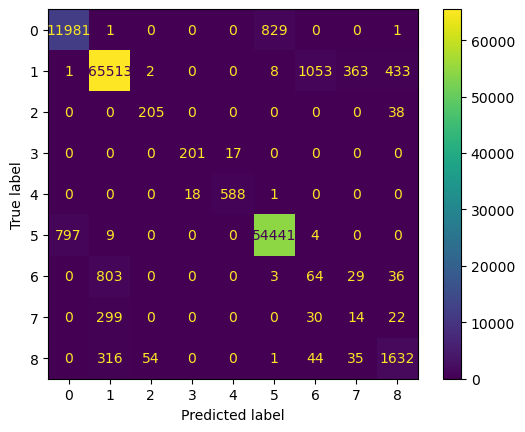

In [68]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay

X = loan_df_cop.drop(['loan_status'],
                     axis=1,
                    )
y = loan_df_cop['loan_status']
dec_tree = DecisionTreeClassifier()
X_train,X_test,y_train,y_test = train_test_split(X,
                                                 y,
                                                 train_size=0.7
                                                )
dec_tree.fit(X_train,y_train)
y_pred = dec_tree.predict(X_test)

ConfusionMatrixDisplay(confusion_matrix(y_pred=y_pred,y_true=y_test)).plot()
print(classification_report(y_pred=y_pred,y_true=y_test))

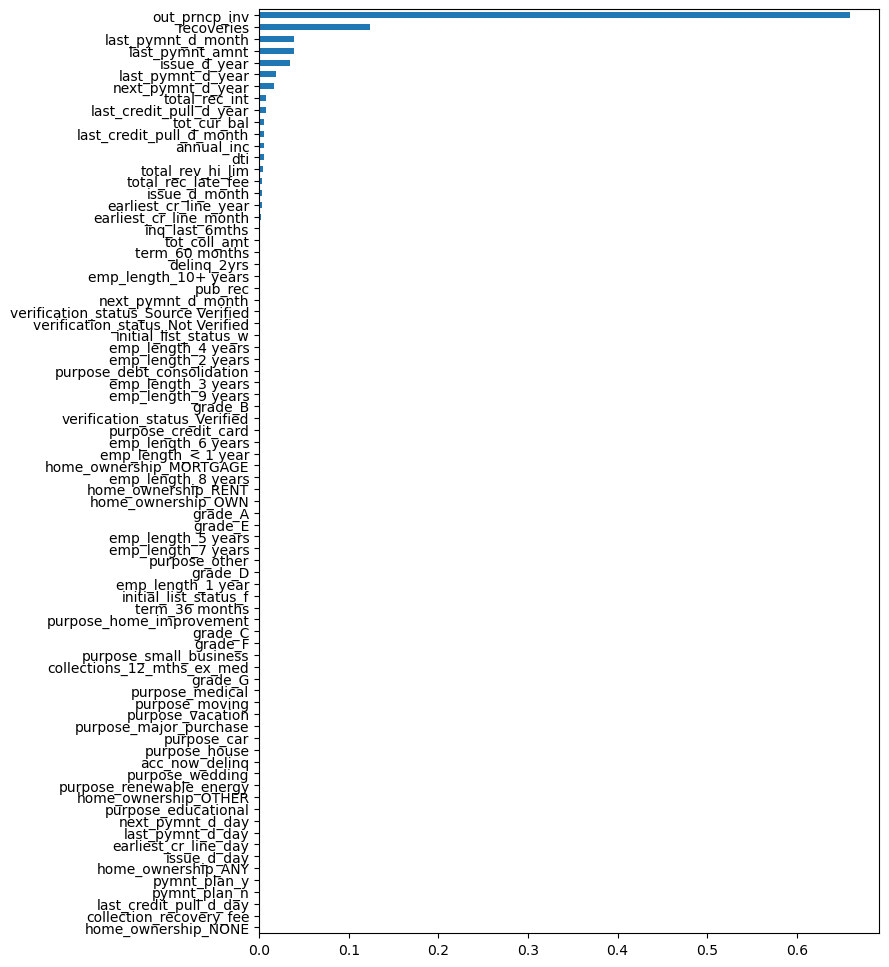

In [69]:
plot_feature_importance(dec_tree, X.columns.tolist(), figsize=(8, 12), orientation='horizontal',ascending=False)

In [70]:
feat_importances = pd.Series(dec_tree.feature_importances_, index=X_train.columns.tolist())
feat_importances = feat_importances.sort_values()
feat_importances[feat_importances<0.01].index.tolist()

['home_ownership_NONE',
 'next_pymnt_d_day',
 'last_pymnt_d_day',
 'earliest_cr_line_day',
 'issue_d_day',
 'purpose_educational',
 'pymnt_plan_y',
 'pymnt_plan_n',
 'home_ownership_ANY',
 'last_credit_pull_d_day',
 'collection_recovery_fee',
 'home_ownership_OTHER',
 'purpose_renewable_energy',
 'purpose_wedding',
 'acc_now_delinq',
 'purpose_house',
 'purpose_car',
 'purpose_major_purchase',
 'purpose_vacation',
 'purpose_moving',
 'purpose_medical',
 'grade_G',
 'collections_12_mths_ex_med',
 'purpose_small_business',
 'grade_F',
 'grade_C',
 'purpose_home_improvement',
 'term_36 months',
 'initial_list_status_f',
 'emp_length_1 year',
 'grade_D',
 'purpose_other',
 'emp_length_7 years',
 'emp_length_5 years',
 'grade_E',
 'grade_A',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'emp_length_8 years',
 'home_ownership_MORTGAGE',
 'emp_length_< 1 year',
 'emp_length_6 years',
 'purpose_credit_card',
 'verification_status_Verified',
 'grade_B',
 'emp_length_9 years',
 'emp_length_3 y

### With Filter Feature Importance

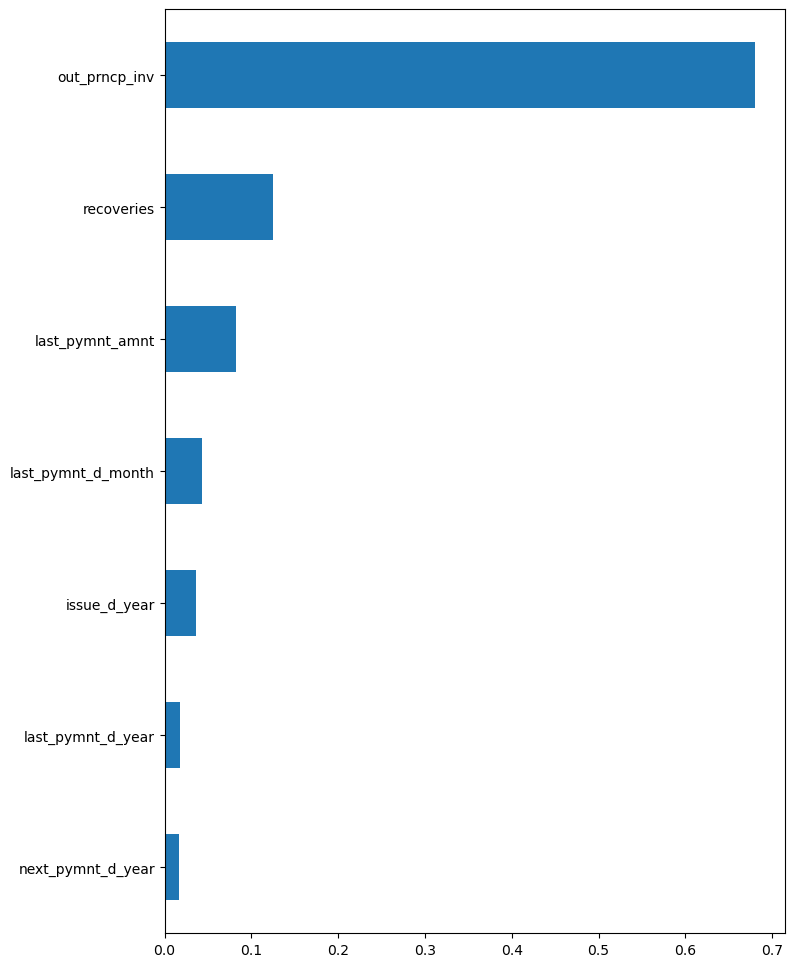

                                                     precision    recall  f1-score   support

                                        Charged Off       0.88      0.88      0.88     12812
                                            Current       0.98      0.98      0.98     67373
                                            Default       0.82      0.83      0.83       243
Does not meet the credit policy. Status:Charged Off       0.91      0.89      0.90       218
 Does not meet the credit policy. Status:Fully Paid       0.95      0.97      0.96       607
                                         Fully Paid       0.97      0.97      0.97     55251
                                    In Grace Period       0.04      0.04      0.04       935
                                  Late (16-30 days)       0.02      0.02      0.02       365
                                 Late (31-120 days)       0.81      0.79      0.80      2082

                                           accuracy                 

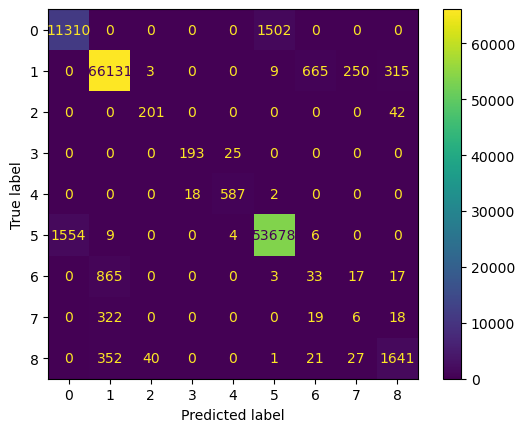

In [71]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,cross_validate

from sklearn.metrics import classification_report
dec_tree = DecisionTreeClassifier()
X_train_mi = X_train.drop(feat_importances[feat_importances<0.01].index.tolist(),axis=1)
X_test_mi  = X_test.drop(feat_importances[feat_importances<0.01].index.tolist(),axis=1)

dec_tree.fit(X_train_mi,y_train)
y_pred = dec_tree.predict(X_test_mi)

plot_feature_importance(dec_tree, X_train_mi.columns.tolist(), figsize=(8, 12), orientation='horizontal',ascending=False)
ConfusionMatrixDisplay(confusion_matrix(y_pred=y_pred,y_true=y_test)).plot()
print(classification_report(y_pred=y_pred,y_true=y_test))

## Random Forest

### Without Filter Feature Importance

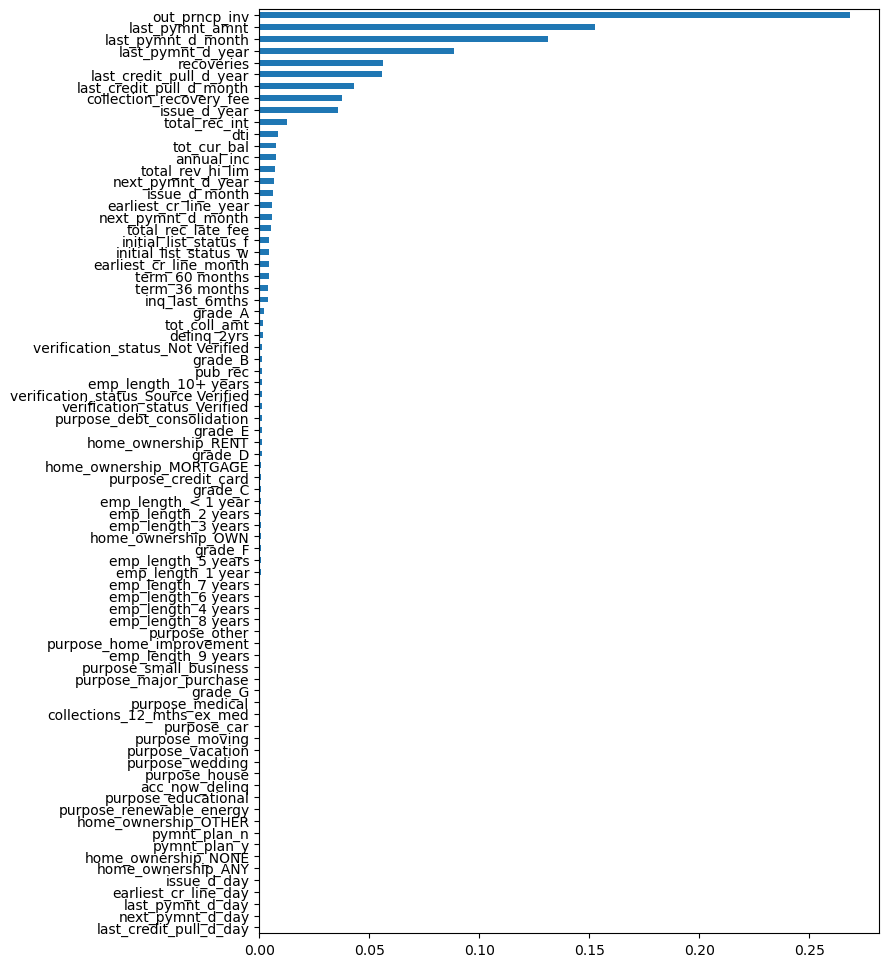

                                                     precision    recall  f1-score   support

                                        Charged Off       0.96      0.93      0.95     12812
                                            Current       0.97      1.00      0.99     67373
                                            Default       0.99      0.56      0.72       243
Does not meet the credit policy. Status:Charged Off       0.93      0.92      0.93       218
 Does not meet the credit policy. Status:Fully Paid       0.97      0.97      0.97       607
                                         Fully Paid       0.98      0.99      0.99     55251
                                    In Grace Period       0.00      0.00      0.00       935
                                  Late (16-30 days)       0.00      0.00      0.00       365
                                 Late (31-120 days)       0.93      0.79      0.85      2082

                                           accuracy                 

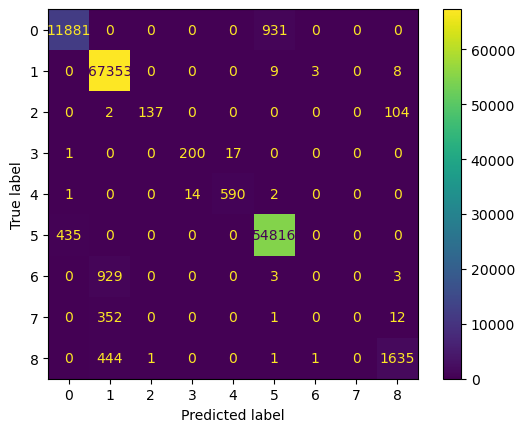

In [72]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,cross_validate

from sklearn.metrics import classification_report
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)

plot_feature_importance(rfc, X_train.columns.tolist(), figsize=(8, 12), orientation='horizontal',ascending=False)
ConfusionMatrixDisplay(confusion_matrix(y_pred=y_pred,y_true=y_test)).plot()
print(classification_report(y_pred=y_pred,y_true=y_test))

### With Filter Feature Importance

In [73]:
feat_importances = pd.Series(rfc.feature_importances_, index=X_train.columns.tolist())
feat_importances = feat_importances.sort_values()
feat_importances[feat_importances<0.01].index.tolist()

['last_credit_pull_d_day',
 'next_pymnt_d_day',
 'last_pymnt_d_day',
 'earliest_cr_line_day',
 'issue_d_day',
 'home_ownership_ANY',
 'home_ownership_NONE',
 'pymnt_plan_y',
 'pymnt_plan_n',
 'home_ownership_OTHER',
 'purpose_renewable_energy',
 'purpose_educational',
 'acc_now_delinq',
 'purpose_house',
 'purpose_wedding',
 'purpose_vacation',
 'purpose_moving',
 'purpose_car',
 'collections_12_mths_ex_med',
 'purpose_medical',
 'grade_G',
 'purpose_major_purchase',
 'purpose_small_business',
 'emp_length_9 years',
 'purpose_home_improvement',
 'purpose_other',
 'emp_length_8 years',
 'emp_length_4 years',
 'emp_length_6 years',
 'emp_length_7 years',
 'emp_length_1 year',
 'emp_length_5 years',
 'grade_F',
 'home_ownership_OWN',
 'emp_length_3 years',
 'emp_length_2 years',
 'emp_length_< 1 year',
 'grade_C',
 'purpose_credit_card',
 'home_ownership_MORTGAGE',
 'grade_D',
 'home_ownership_RENT',
 'grade_E',
 'purpose_debt_consolidation',
 'verification_status_Verified',
 'verificatio

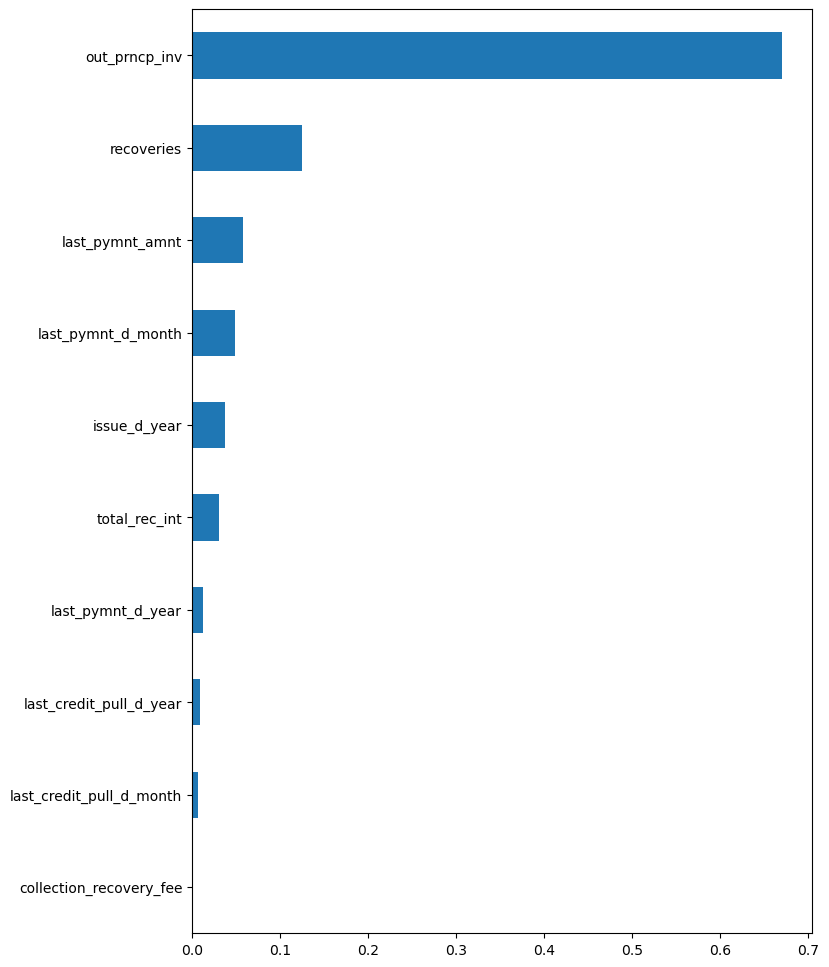

                                                     precision    recall  f1-score   support

                                        Charged Off       0.93      0.92      0.93     12812
                                            Current       0.98      0.98      0.98     67373
                                            Default       0.81      0.83      0.82       243
Does not meet the credit policy. Status:Charged Off       0.29      0.32      0.30       218
 Does not meet the credit policy. Status:Fully Paid       0.24      0.25      0.24       607
                                         Fully Paid       0.98      0.98      0.98     55251
                                    In Grace Period       0.04      0.04      0.04       935
                                  Late (16-30 days)       0.03      0.03      0.03       365
                                 Late (31-120 days)       0.81      0.78      0.79      2082

                                           accuracy                 

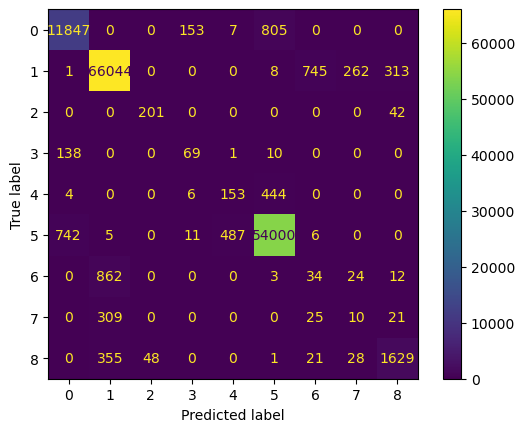

In [74]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,cross_validate

from sklearn.metrics import classification_report
dec_tree = DecisionTreeClassifier()
X_train_mi = X_train.drop(feat_importances[feat_importances<0.01].index.tolist(),axis=1)
X_test_mi  = X_test.drop(feat_importances[feat_importances<0.01].index.tolist(),axis=1)

dec_tree.fit(X_train_mi,y_train)
y_pred = dec_tree.predict(X_test_mi)

plot_feature_importance(dec_tree, X_train_mi.columns.tolist(), figsize=(8, 12), orientation='horizontal',ascending=False)
ConfusionMatrixDisplay(confusion_matrix(y_pred=y_pred,y_true=y_test)).plot()
print(classification_report(y_pred=y_pred,y_true=y_test))

# Machine Learning with Sklearn with SMOTE

## Decision Tree

### Without Filter Feature Importance

In [75]:
from imblearn.over_sampling import SMOTE

smoteku = SMOTE(random_state=42)
X = loan_df_cop.drop(['loan_status'],
                     axis=1,
                    )
y = loan_df_cop['loan_status']
X_res, y_res = smoteku.fit_resample(X, y)
print(X_res.shape)

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7e5906ce1c60>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 584, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 725, in _make_controller_from_path
    lib_controller = lib_controller_class(
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 842, in __init__
    super().__init__(**kwargs)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 810, in __init__
    self._dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/opt/conda/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: dlopen() error


(2018034, 78)


In [76]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
dec_tree = DecisionTreeClassifier()
X_train,X_test,y_train,y_test = train_test_split(X_res,
                                                 y_res,
                                                 train_size=0.7
                                                )
dec_tree.fit(X_train,y_train)
y_pred = dec_tree.predict(X_test)
y_pred

array(['Does not meet the credit policy. Status:Charged Off',
       'Late (16-30 days)', 'Current', ..., 'Late (31-120 days)',
       'Fully Paid', 'Late (31-120 days)'], dtype=object)

                                                     precision    recall  f1-score   support

                                        Charged Off       0.98      0.98      0.98     67162
                                            Current       0.98      0.97      0.97     67461
                                            Default       0.99      0.99      0.99     66762
Does not meet the credit policy. Status:Charged Off       1.00      1.00      1.00     67485
 Does not meet the credit policy. Status:Fully Paid       1.00      1.00      1.00     67363
                                         Fully Paid       0.98      0.98      0.98     67363
                                    In Grace Period       0.94      0.95      0.94     67082
                                  Late (16-30 days)       0.98      0.98      0.98     67296
                                 Late (31-120 days)       0.96      0.95      0.95     67437

                                           accuracy                 

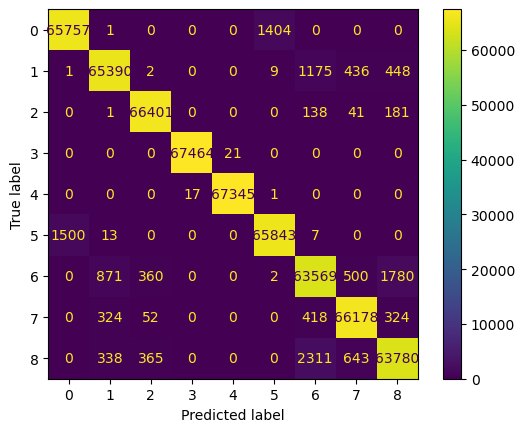

In [77]:
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix(y_pred=y_pred,y_true=y_test)).plot()
print(classification_report(y_pred=y_pred,y_true=y_test))

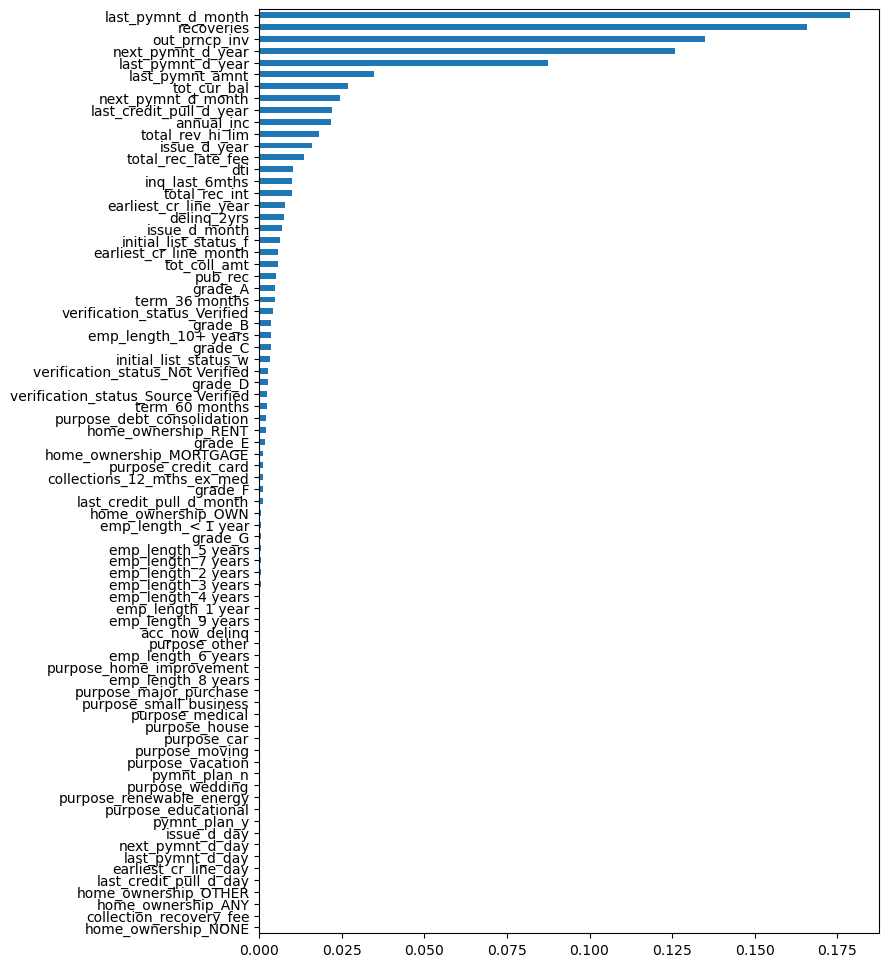

In [78]:
plot_feature_importance(dec_tree, X_res.columns.tolist(), figsize=(8, 12), orientation='horizontal',ascending=False)

In [79]:
feat_importances = pd.Series(dec_tree.feature_importances_, index=X_res.columns.tolist())
feat_importances = feat_importances.sort_values()
feat_importances[feat_importances<0.01].index.tolist()

['home_ownership_NONE',
 'next_pymnt_d_day',
 'last_pymnt_d_day',
 'earliest_cr_line_day',
 'issue_d_day',
 'home_ownership_OTHER',
 'home_ownership_ANY',
 'collection_recovery_fee',
 'last_credit_pull_d_day',
 'pymnt_plan_y',
 'purpose_educational',
 'purpose_renewable_energy',
 'purpose_wedding',
 'pymnt_plan_n',
 'purpose_vacation',
 'purpose_moving',
 'purpose_car',
 'purpose_house',
 'purpose_medical',
 'purpose_small_business',
 'purpose_major_purchase',
 'emp_length_8 years',
 'purpose_home_improvement',
 'emp_length_6 years',
 'purpose_other',
 'acc_now_delinq',
 'emp_length_9 years',
 'emp_length_1 year',
 'emp_length_4 years',
 'emp_length_3 years',
 'emp_length_2 years',
 'emp_length_7 years',
 'emp_length_5 years',
 'grade_G',
 'emp_length_< 1 year',
 'home_ownership_OWN',
 'last_credit_pull_d_month',
 'grade_F',
 'collections_12_mths_ex_med',
 'purpose_credit_card',
 'home_ownership_MORTGAGE',
 'grade_E',
 'home_ownership_RENT',
 'purpose_debt_consolidation',
 'term_60 mon

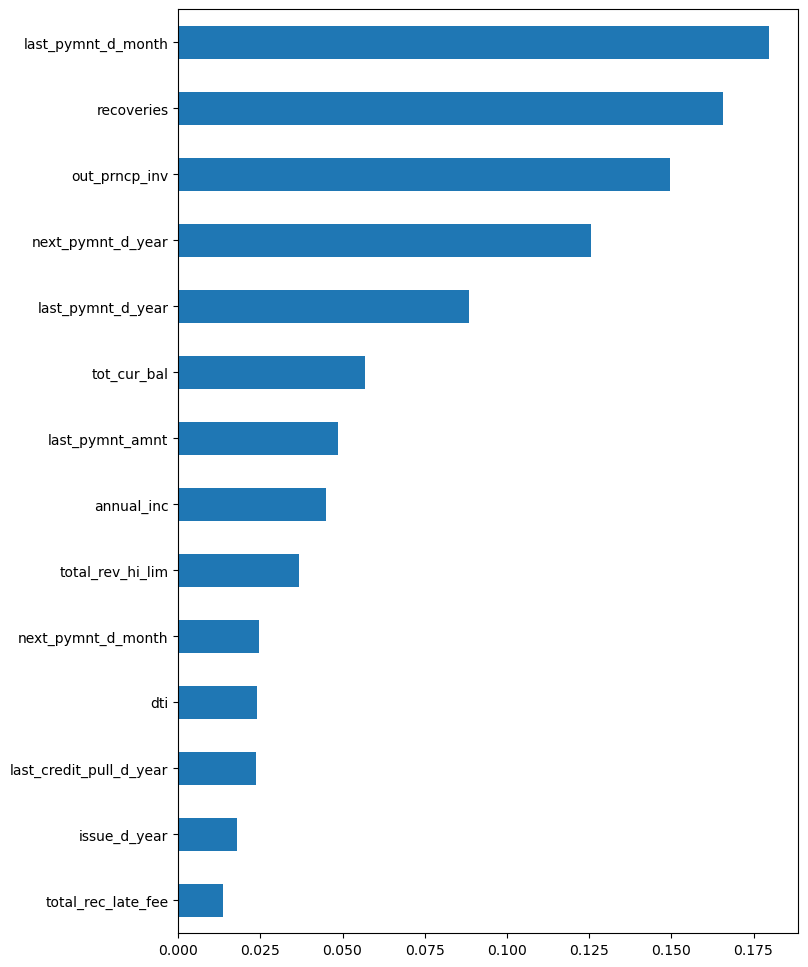

                                                     precision    recall  f1-score   support

                                        Charged Off       0.97      0.97      0.97     67162
                                            Current       0.96      0.93      0.94     67461
                                            Default       0.99      0.99      0.99     66762
Does not meet the credit policy. Status:Charged Off       1.00      1.00      1.00     67485
 Does not meet the credit policy. Status:Fully Paid       1.00      1.00      1.00     67363
                                         Fully Paid       0.97      0.97      0.97     67363
                                    In Grace Period       0.92      0.94      0.93     67082
                                  Late (16-30 days)       0.96      0.98      0.97     67296
                                 Late (31-120 days)       0.95      0.95      0.95     67437

                                           accuracy                 

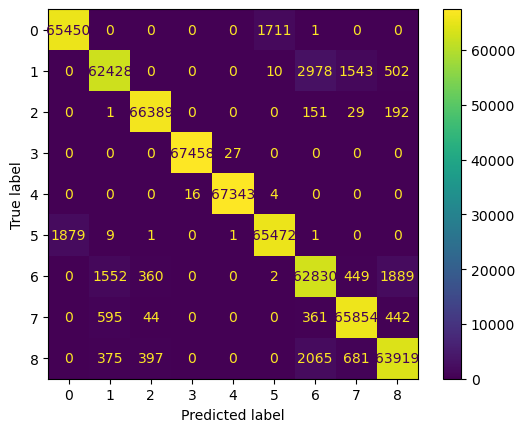

In [80]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,cross_validate

from sklearn.metrics import classification_report
dec_tree = DecisionTreeClassifier()
# X_train,X_test,y_train,y_test = train_test_split(X_res_mi,
#                                                  y_res,
#                                                  train_size=0.7
#                                                 )
X_train_mi = X_train.drop(feat_importances[feat_importances<0.01].index.tolist(),axis=1)
X_test_mi  = X_test.drop(feat_importances[feat_importances<0.01].index.tolist(),axis=1)

dec_tree.fit(X_train_mi,y_train)
y_pred = dec_tree.predict(X_test_mi)

plot_feature_importance(dec_tree, X_train_mi.columns.tolist(), figsize=(8, 12), orientation='horizontal',ascending=False)
ConfusionMatrixDisplay(confusion_matrix(y_pred=y_pred,y_true=y_test)).plot()
print(classification_report(y_pred=y_pred,y_true=y_test))

# clf = DecisionTreeClassifier(random_state=0)
# scoring = ['f1_macro']
# scores = cross_validate(clf, X_res_mi, y_res, scoring=scoring, return_estimator=True)

# for estimator in scores['estimator']:
#     y_pred = estimator.predict(X_res_mi)
#     print(estimator)
#     print(classification_report(y_res, y_pred))

# # print(classification_report(y_pred=y_pred,y_true=y_test))

## Random Forest

### Without filter Feature Importance

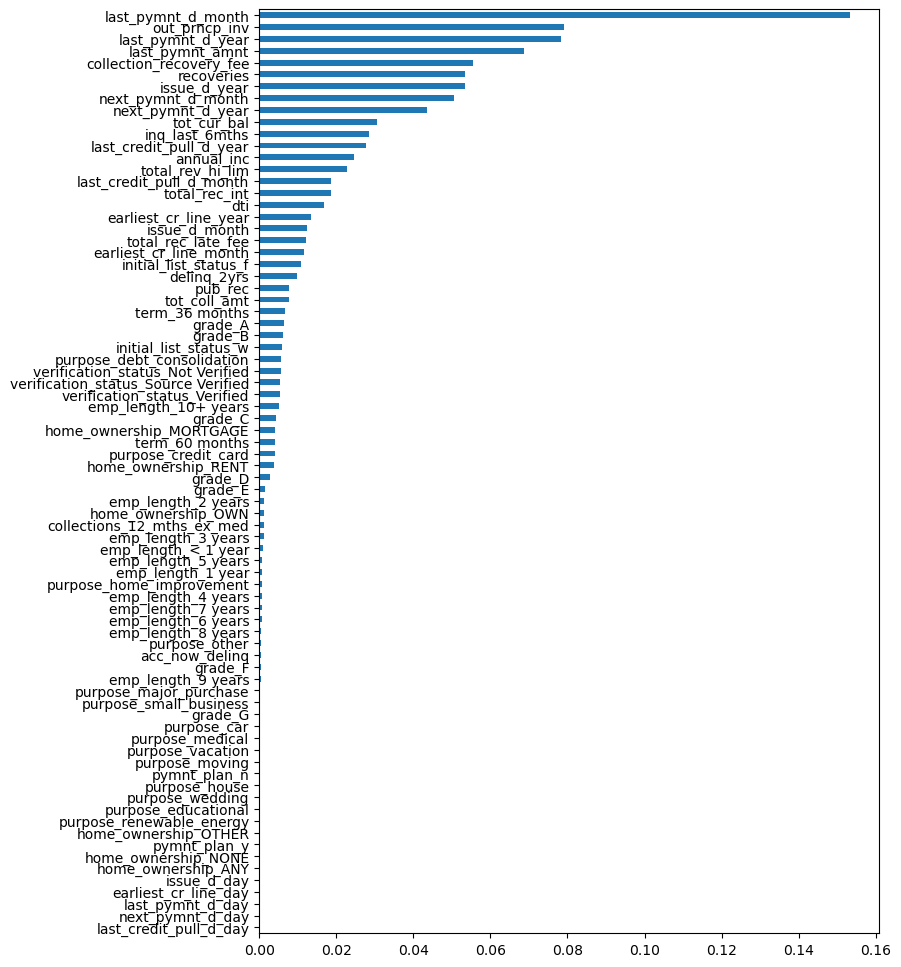

                                                     precision    recall  f1-score   support

                                        Charged Off       0.99      0.98      0.99     67162
                                            Current       0.98      1.00      0.99     67461
                                            Default       1.00      1.00      1.00     66762
Does not meet the credit policy. Status:Charged Off       1.00      1.00      1.00     67485
 Does not meet the credit policy. Status:Fully Paid       1.00      1.00      1.00     67363
                                         Fully Paid       0.98      0.99      0.99     67363
                                    In Grace Period       1.00      0.98      0.99     67082
                                  Late (16-30 days)       1.00      0.99      1.00     67296
                                 Late (31-120 days)       0.99      0.99      0.99     67437

                                           accuracy                 

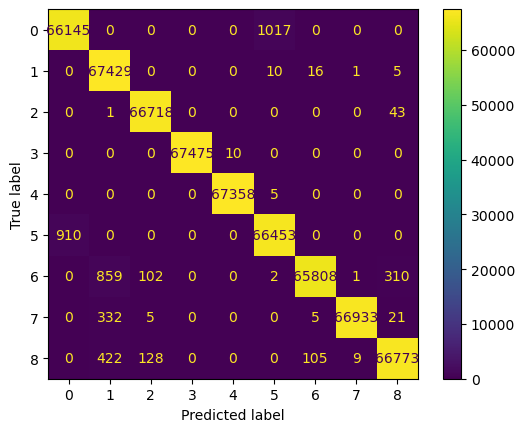

In [81]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,cross_validate

from sklearn.metrics import classification_report
rfc = RandomForestClassifier()
# X_train,X_test,y_train,y_test = train_test_split(X_res_mi,
#                                                  y_res,
#                                                  train_size=0.7
#                                                 )
# X_train_mi = X_train.drop(feat_importances[feat_importances<0.01].index.tolist(),axis=1)
# X_test_mi  = X_test.drop(feat_importances[feat_importances<0.01].index.tolist(),axis=1)

rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)

plot_feature_importance(rfc, X_train.columns.tolist(), figsize=(8, 12), orientation='horizontal',ascending=False)
ConfusionMatrixDisplay(confusion_matrix(y_pred=y_pred,y_true=y_test)).plot()
print(classification_report(y_pred=y_pred,y_true=y_test))

# clf = DecisionTreeClassifier(random_state=0)
# scoring = ['f1_macro']
# scores = cross_validate(clf, X_res_mi, y_res, scoring=scoring, return_estimator=True)

# for estimator in scores['estimator']:
#     y_pred = estimator.predict(X_res_mi)
#     print(estimator)
#     print(classification_report(y_res, y_pred))

# # print(classification_report(y_pred=y_pred,y_true=y_test))

In [82]:
feat_importances = pd.Series(rfc.feature_importances_, index=X_train.columns.tolist())
feat_importances = feat_importances.sort_values()
feat_importances[feat_importances<0.01].index.tolist()

['last_credit_pull_d_day',
 'next_pymnt_d_day',
 'last_pymnt_d_day',
 'earliest_cr_line_day',
 'issue_d_day',
 'home_ownership_ANY',
 'home_ownership_NONE',
 'pymnt_plan_y',
 'home_ownership_OTHER',
 'purpose_renewable_energy',
 'purpose_educational',
 'purpose_wedding',
 'purpose_house',
 'pymnt_plan_n',
 'purpose_moving',
 'purpose_vacation',
 'purpose_medical',
 'purpose_car',
 'grade_G',
 'purpose_small_business',
 'purpose_major_purchase',
 'emp_length_9 years',
 'grade_F',
 'acc_now_delinq',
 'purpose_other',
 'emp_length_8 years',
 'emp_length_6 years',
 'emp_length_7 years',
 'emp_length_4 years',
 'purpose_home_improvement',
 'emp_length_1 year',
 'emp_length_5 years',
 'emp_length_< 1 year',
 'emp_length_3 years',
 'collections_12_mths_ex_med',
 'home_ownership_OWN',
 'emp_length_2 years',
 'grade_E',
 'grade_D',
 'home_ownership_RENT',
 'purpose_credit_card',
 'term_60 months',
 'home_ownership_MORTGAGE',
 'grade_C',
 'emp_length_10+ years',
 'verification_status_Verified',


### With Feature Importance

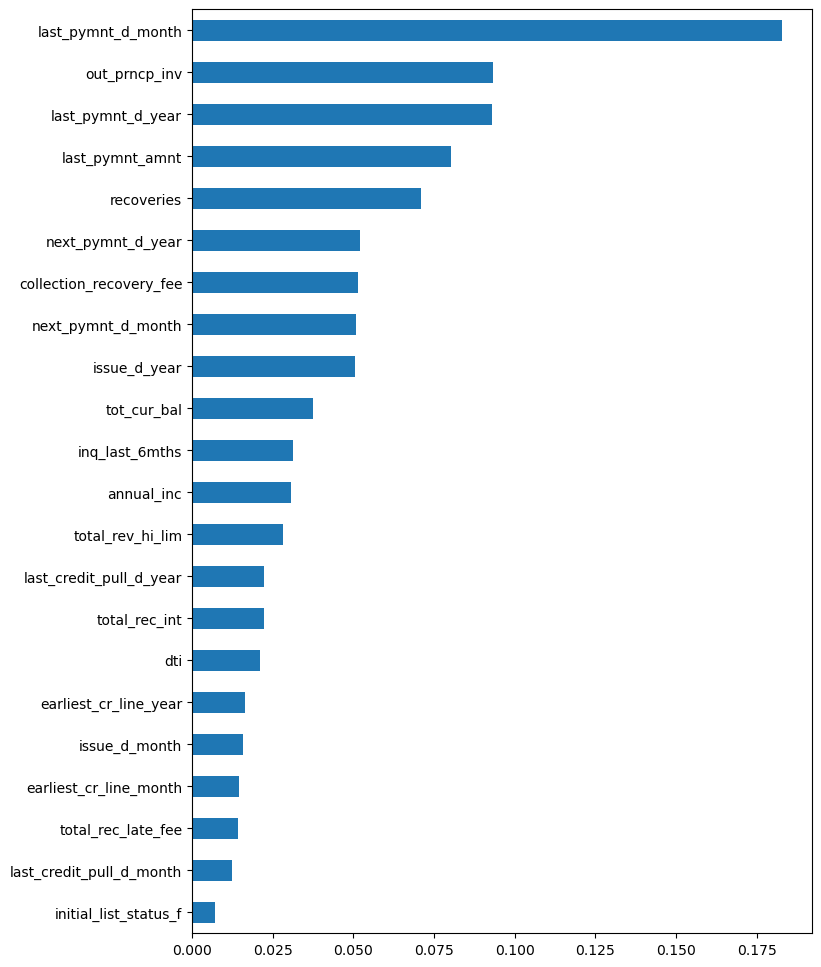

                                                     precision    recall  f1-score   support

                                        Charged Off       0.99      0.99      0.99     67162
                                            Current       0.98      0.98      0.98     67461
                                            Default       0.99      1.00      1.00     66762
Does not meet the credit policy. Status:Charged Off       1.00      1.00      1.00     67485
 Does not meet the credit policy. Status:Fully Paid       1.00      1.00      1.00     67363
                                         Fully Paid       0.99      0.99      0.99     67363
                                    In Grace Period       0.98      0.98      0.98     67082
                                  Late (16-30 days)       1.00      1.00      1.00     67296
                                 Late (31-120 days)       0.99      0.99      0.99     67437

                                           accuracy                 

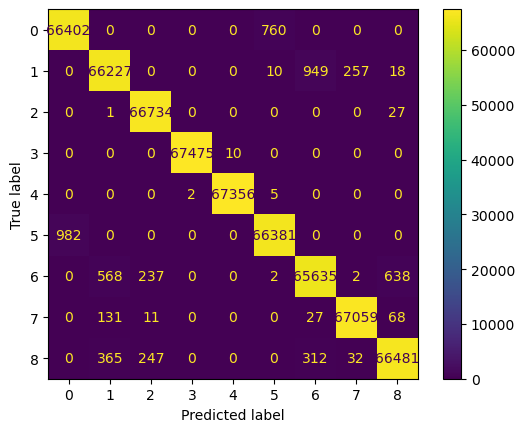

In [83]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,cross_validate

from sklearn.metrics import classification_report
rfc = RandomForestClassifier()
X_train_mi = X_train.drop(feat_importances[feat_importances<0.01].index.tolist(),axis=1)
X_test_mi  = X_test.drop(feat_importances[feat_importances<0.01].index.tolist(),axis=1)

rfc.fit(X_train_mi,y_train)
y_pred = rfc.predict(X_test_mi)

plot_feature_importance(rfc, X_train_mi.columns.tolist(), figsize=(8, 12), orientation='horizontal',ascending=False)
ConfusionMatrixDisplay(confusion_matrix(y_pred=y_pred,y_true=y_test)).plot()
print(classification_report(y_pred=y_pred,y_true=y_test))

# Machine Learning With Pyspark

In [84]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [85]:
spark = SparkSession.builder.appName("PandasToPySpark").config("spark.driver.memory", "8g").config("spark.executor.memory", "8g").getOrCreate()
spark_df = spark.createDataFrame(loan_df_cop)
spark_df

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/02 12:02:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


DataFrame[annual_inc: double, loan_status: string, dti: double, delinq_2yrs: double, inq_last_6mths: double, pub_rec: double, out_prncp_inv: double, total_rec_int: double, total_rec_late_fee: double, recoveries: double, collection_recovery_fee: double, last_pymnt_amnt: double, collections_12_mths_ex_med: double, acc_now_delinq: double, tot_coll_amt: double, tot_cur_bal: double, total_rev_hi_lim: double, term_36 months: bigint, term_60 months: bigint, grade_A: bigint, grade_B: bigint, grade_C: bigint, grade_D: bigint, grade_E: bigint, grade_F: bigint, grade_G: bigint, emp_length_1 year: bigint, emp_length_10+ years: bigint, emp_length_2 years: bigint, emp_length_3 years: bigint, emp_length_4 years: bigint, emp_length_5 years: bigint, emp_length_6 years: bigint, emp_length_7 years: bigint, emp_length_8 years: bigint, emp_length_9 years: bigint, emp_length_< 1 year: bigint, home_ownership_ANY: bigint, home_ownership_MORTGAGE: bigint, home_ownership_NONE: bigint, home_ownership_OTHER: bigi

In [86]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

# cat_col = ['term',
#            'grade',
#            'home_ownership',
#            'verification_status',
           #'loan_status',
#            'pymnt_plan',
#            'purpose',
#            'initial_list_status']
# One-hot encode the categorical variables
# indexers = [StringIndexer(inputCol=colu, outputCol=colu+"_index") for colu in cat_col]
# encoders = [OneHotEncoder(inputCol=colu+"_index", outputCol=colu+"_vec") for colu in cat_col]
# label_indexer = StringIndexer(inputCol="loan_status", outputCol="loan_status_index")
# pipeline = Pipeline(stages=indexers + encoders + [label_indexer])
# spark_df = pipeline.fit(spark_df).transform(spark_df)
spark_df.printSchema()

root
 |-- annual_inc: double (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- dti: double (nullable = true)
 |-- delinq_2yrs: double (nullable = true)
 |-- inq_last_6mths: double (nullable = true)
 |-- pub_rec: double (nullable = true)
 |-- out_prncp_inv: double (nullable = true)
 |-- total_rec_int: double (nullable = true)
 |-- total_rec_late_fee: double (nullable = true)
 |-- recoveries: double (nullable = true)
 |-- collection_recovery_fee: double (nullable = true)
 |-- last_pymnt_amnt: double (nullable = true)
 |-- collections_12_mths_ex_med: double (nullable = true)
 |-- acc_now_delinq: double (nullable = true)
 |-- tot_coll_amt: double (nullable = true)
 |-- tot_cur_bal: double (nullable = true)
 |-- total_rev_hi_lim: double (nullable = true)
 |-- term_36 months: long (nullable = true)
 |-- term_60 months: long (nullable = true)
 |-- grade_A: long (nullable = true)
 |-- grade_B: long (nullable = true)
 |-- grade_C: long (nullable = true)
 |-- grade_D: long (nulla

In [87]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler

spark_df_cop = spark_df
# spark_df_cop = spark_df_cop.repartition(numPartitions=100)
feature_list = spark_df_cop.columns
feature_list.remove('loan_status')
feature_list

vec = VectorAssembler(inputCols=feature_list, outputCol = "features")
spark_df_cop = vec.transform(spark_df_cop)

indexer = StringIndexer(inputCol="loan_status", outputCol="loan_status_index")
indexer_fit = indexer.fit(spark_df_cop)
spark_df_cop = indexer_fit.transform(spark_df_cop)

train, test = spark_df_cop.randomSplit([0.8, 0.2], seed=42)

rf = RandomForestClassifier(labelCol="loan_status_index", featuresCol="features", numTrees=100)
pipeline = Pipeline(stages=[rf])
model = pipeline.fit(train)

# Make predictions
predictions = model.transform(test)

# Evaluate model
evaluator = MulticlassClassificationEvaluator(labelCol="loan_status_index", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Accuracy = %g" % accuracy)

23/07/02 12:07:11 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/07/02 12:07:12 WARN TaskSetManager: Stage 0 contains a task of very large size (31717 KiB). The maximum recommended task size is 1000 KiB.
23/07/02 12:07:21 WARN TaskSetManager: Stage 3 contains a task of very large size (31717 KiB). The maximum recommended task size is 1000 KiB.
23/07/02 12:07:26 WARN TaskSetManager: Stage 4 contains a task of very large size (31717 KiB). The maximum recommended task size is 1000 KiB.
23/07/02 12:07:36 WARN TaskSetManager: Stage 5 contains a task of very large size (31717 KiB). The maximum recommended task size is 1000 KiB.
23/07/02 12:07:46 WARN TaskSetManager: Stage 7 contains a task of very large size (31717 KiB). The maximum recommended task size is 1000 KiB.
23/07/02 12:08:01 WARN TaskSetManager: Stage 9 contains a task of very large size (31717 KiB). The maximum rec

Test Accuracy = 0.926411


In [88]:
# Generate classification report
labels = indexer_fit.labels # Get the label names from the indexer
predictions_df = predictions.select("loan_status_index", "prediction").toPandas() # Convert predictions to pandas dataframe
report_df = pd.crosstab(predictions_df["loan_status_index"], predictions_df["prediction"], rownames=["Actual"], colnames=["Predicted"]) # Create a confusion matrix
# report_df.index = labels # Replace the numeric indices with label names
# report_df.columns = labels # Replace the numeric indices with label names
print(report_df) # Print the classification report

23/07/02 12:08:35 WARN TaskSetManager: Stage 19 contains a task of very large size (31717 KiB). The maximum recommended task size is 1000 KiB.


Predicted    0.0    1.0   2.0  5.0  8.0
Actual                                 
0.0        44778     18     0    0    0
1.0          294  36761     0    0    0
2.0            6   3793  4730    0    0
3.0         1365     12     0    0    0
4.0          609      2     0    0    0
5.0            0    306     0   83    0
6.0          229      0     0    0    0
7.0          160      3     0    0    0
8.0            0     58     9    2   84


In [89]:
my_dict = {i: indexer_fit.labels[i] for i in range(len(indexer_fit.labels))}
my_dict

{0: 'Current',
 1: 'Fully Paid',
 2: 'Charged Off',
 3: 'Late (31-120 days)',
 4: 'In Grace Period',
 5: 'Does not meet the credit policy. Status:Fully Paid',
 6: 'Late (16-30 days)',
 7: 'Default',
 8: 'Does not meet the credit policy. Status:Charged Off'}

Predicted is not good , because predicted and Actual not same element

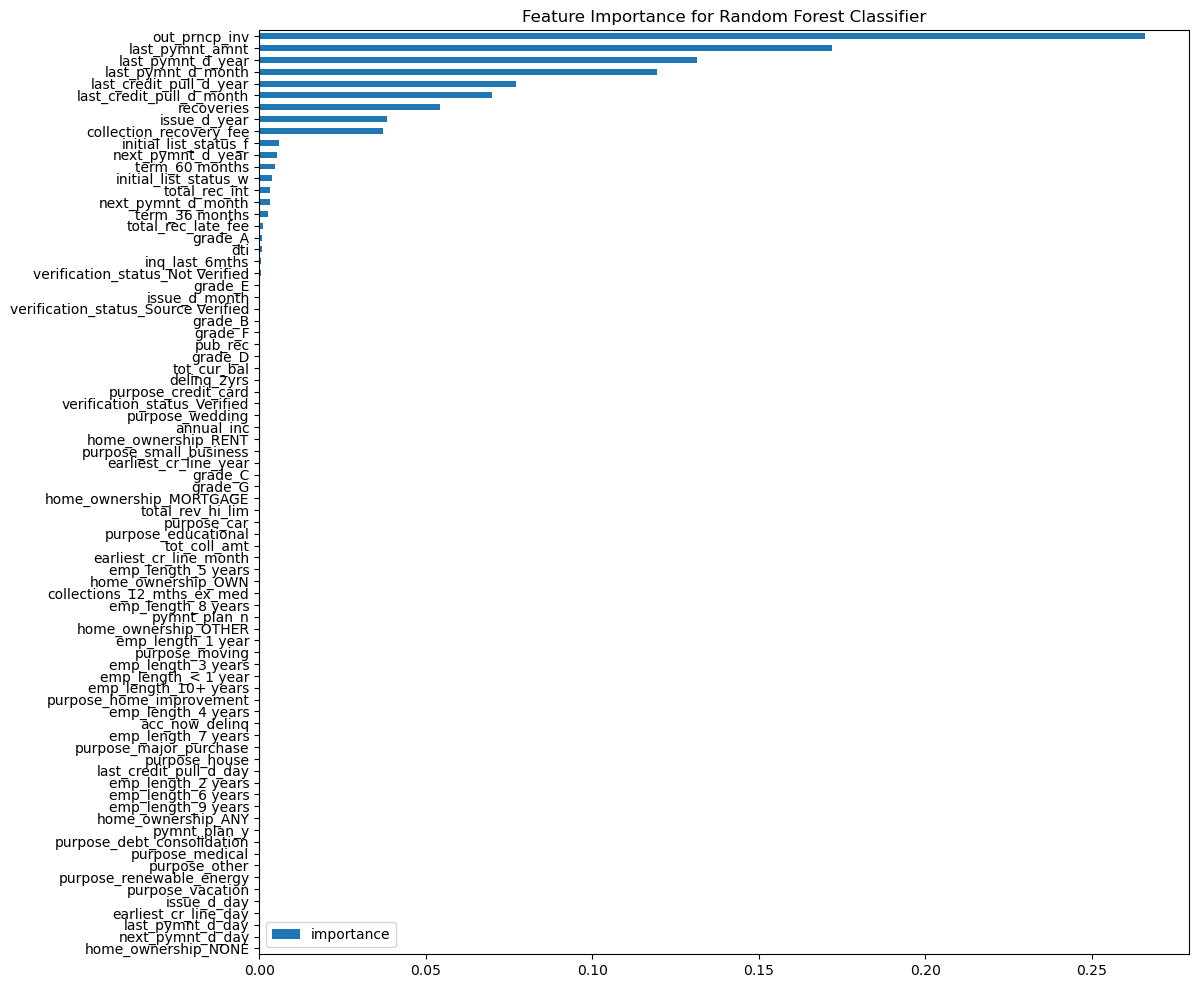

In [90]:
# Plot feature importance
rf_model = model.stages[0] # Get the random forest model from the pipeline
feature_importance = rf_model.featureImportances # Get the feature importance vector
feature_importance_df = pd.DataFrame(feature_importance.toArray(), index=feature_list, columns=["importance"]) # Create a pandas dataframe with feature names and importance values
feature_importance_df.sort_values(by="importance", ascending=True, inplace=True) # Sort the dataframe by importance values
feature_importance_df.plot(kind="barh", figsize=(12, 12)) # Plot the dataframe as a bar chart
plt.title("Feature Importance for Random Forest Classifier") # Add a title to the plot
plt.show() # Show the plot

In [91]:
loan_df_cop_smote = X_res.merge(y_res.to_frame(),left_index=True,right_index=True)
loan_df_cop_smote

,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,out_prncp_inv,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,...,last_pymnt_d_year,last_pymnt_d_month,last_pymnt_d_day,next_pymnt_d_year,next_pymnt_d_month,next_pymnt_d_day,last_credit_pull_d_year,last_credit_pull_d_month,last_credit_pull_d_day,loan_status
0,24000.000000,27.650000,0.000000,1.000000,0.000000,0.000000,861.070000,0.000000,0.00,0.00,...,2015,1,1,2016,2,1,2016,1,1,Fully Paid
1,30000.000000,1.000000,0.000000,5.000000,0.000000,0.000000,435.170000,0.000000,117.08,1.11,...,2013,4,1,2016,2,1,2013,9,1,Charged Off
2,12252.000000,8.720000,0.000000,2.000000,0.000000,0.000000,603.650000,0.000000,0.00,0.00,...,2014,6,1,2016,2,1,2016,1,1,Fully Paid
3,49200.000000,20.000000,0.000000,1.000000,0.000000,0.000000,2209.330000,16.970000,0.00,0.00,...,2015,1,1,2016,2,1,2015,1,1,Fully Paid
4,80000.000000,17.940000,0.000000,0.000000,0.000000,766.900000,1009.070000,0.000000,0.00,0.00,...,2016,1,1,2016,2,1,2016,1,1,Current
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018029,70038.416719,14.206008,0.092944,0.969019,0.000000,3337.533559,1767.974054,0.000000,0.00,0.00,...,2015,1,1,2016,2,1,2016,1,1,Late (31-120 days)
2018030,135174.334070,15.293577,2.587167,0.000000,0.000000,17655.371192,3726.734643,0.000000,0.00,0.00,...,2015,11,1,2016,1,1,2016,1,1,Late (31-120 days)
2018031,61345.077367,18.094637,0.000000,0.336269,0.000000,20688.954772,3748.113890,0.000000,0.00,0.00,...,2015,9,1,2016,2,1,2016,1,1,Late (31-120 days)
2018032,49772.164015,23.477741,2.326666,0.673334,0.000000,5924.039149,1582.322337,28.010687,0.00,0.00,...,2015,10,1,2016,2,1,2016,1,1,Late (31-120 days)


In [92]:
spark.stop()
del spark

# Spark Smote

In [93]:
spark = SparkSession.builder.appName("PandasToPySpark_2").config("spark.driver.memory", "8g").config("spark.executor.memory", "8g").getOrCreate()
spark_df_smote = spark.createDataFrame(loan_df_cop_smote)
spark_df_smote

DataFrame[annual_inc: double, dti: double, delinq_2yrs: double, inq_last_6mths: double, pub_rec: double, out_prncp_inv: double, total_rec_int: double, total_rec_late_fee: double, recoveries: double, collection_recovery_fee: double, last_pymnt_amnt: double, collections_12_mths_ex_med: double, acc_now_delinq: double, tot_coll_amt: double, tot_cur_bal: double, total_rev_hi_lim: double, term_36 months: bigint, term_60 months: bigint, grade_A: bigint, grade_B: bigint, grade_C: bigint, grade_D: bigint, grade_E: bigint, grade_F: bigint, grade_G: bigint, emp_length_1 year: bigint, emp_length_10+ years: bigint, emp_length_2 years: bigint, emp_length_3 years: bigint, emp_length_4 years: bigint, emp_length_5 years: bigint, emp_length_6 years: bigint, emp_length_7 years: bigint, emp_length_8 years: bigint, emp_length_9 years: bigint, emp_length_< 1 year: bigint, home_ownership_ANY: bigint, home_ownership_MORTGAGE: bigint, home_ownership_NONE: bigint, home_ownership_OTHER: bigint, home_ownership_OW

In [94]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler

spark_df_cop = spark_df_smote
# spark_df_cop = spark_df_cop.repartition(numPartitions=100)
feature_list = spark_df_cop.columns
feature_list.remove('loan_status')
feature_list

vec = VectorAssembler(inputCols=feature_list, outputCol = "features")
spark_df_cop = vec.transform(spark_df_cop)

indexer = StringIndexer(inputCol="loan_status", outputCol="loan_status_index")
indexer_fit = indexer.fit(spark_df_cop)
spark_df_cop = indexer_fit.transform(spark_df_cop)

train, test = spark_df_cop.randomSplit([0.8, 0.2], seed=42)

rf = RandomForestClassifier(labelCol="loan_status_index", featuresCol="features", numTrees=100)
pipeline = Pipeline(stages=[rf])
model = pipeline.fit(train)

# Make predictions
predictions = model.transform(test)

# Evaluate model
evaluator = MulticlassClassificationEvaluator(labelCol="loan_status_index", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Accuracy = %g" % accuracy)

23/07/02 12:27:41 WARN TaskSetManager: Stage 0 contains a task of very large size (137294 KiB). The maximum recommended task size is 1000 KiB.
23/07/02 12:27:56 WARN TaskSetManager: Stage 3 contains a task of very large size (137294 KiB). The maximum recommended task size is 1000 KiB.
23/07/02 12:28:12 WARN TaskSetManager: Stage 4 contains a task of very large size (137294 KiB). The maximum recommended task size is 1000 KiB.
23/07/02 12:28:46 WARN TaskSetManager: Stage 5 contains a task of very large size (137294 KiB). The maximum recommended task size is 1000 KiB.
23/07/02 12:29:23 WARN TaskSetManager: Stage 7 contains a task of very large size (137294 KiB). The maximum recommended task size is 1000 KiB.
23/07/02 12:30:19 WARN TaskSetManager: Stage 9 contains a task of very large size (137294 KiB). The maximum recommended task size is 1000 KiB.
23/07/02 12:30:37 WARN TaskSetManager: Stage 11 contains a task of very large size (137294 KiB). The maximum recommended task size is 1000 KiB

Test Accuracy = 0.754695


In [95]:
# Generate classification report
labels = indexer_fit.labels # Get the label names from the indexer
predictions_df = predictions.select("loan_status_index", "prediction").toPandas() # Convert predictions to pandas dataframe
report_df = pd.crosstab(predictions_df["loan_status_index"], predictions_df["prediction"], rownames=["Actual"], colnames=["Predicted"]) # Create a confusion matrix
my_dict = {i: indexer_fit.labels[i] for i in range(len(indexer_fit.labels))}
print(my_dict)
print()
#report_df.index = labels # Replace the numeric indices with label names
#report_df.columns = labels # Replace the numeric indices with label names
print(report_df) # Print the classification report

23/07/02 12:32:36 WARN TaskSetManager: Stage 19 contains a task of very large size (137294 KiB). The maximum recommended task size is 1000 KiB.


{0: 'Charged Off', 1: 'Current', 2: 'Default', 3: 'Does not meet the credit policy. Status:Charged Off', 4: 'Does not meet the credit policy. Status:Fully Paid', 5: 'Fully Paid', 6: 'In Grace Period', 7: 'Late (16-30 days)', 8: 'Late (31-120 days)'}

Predicted    0.0    1.0    2.0    3.0    4.0    5.0   6.0    7.0    8.0
Actual                                                                 
0.0        35575      3      0     13     59   9233     0      0      0
1.0            0  37470      0      0      0     48  1508   5930      0
2.0            0    165  36848      0      0    867     0     42   6888
3.0            0      0      0  42627   2111      0     0      0      0
4.0            0      0      0     15  45026      2     0      0      0
5.0           38    107      0      0    264  44430     0      0      0
6.0            0   4448  10272      0      0    321  1860  22775   5088
7.0            0    602   2876      0      0    261   877  34847   5419
8.0            0   1571  1565

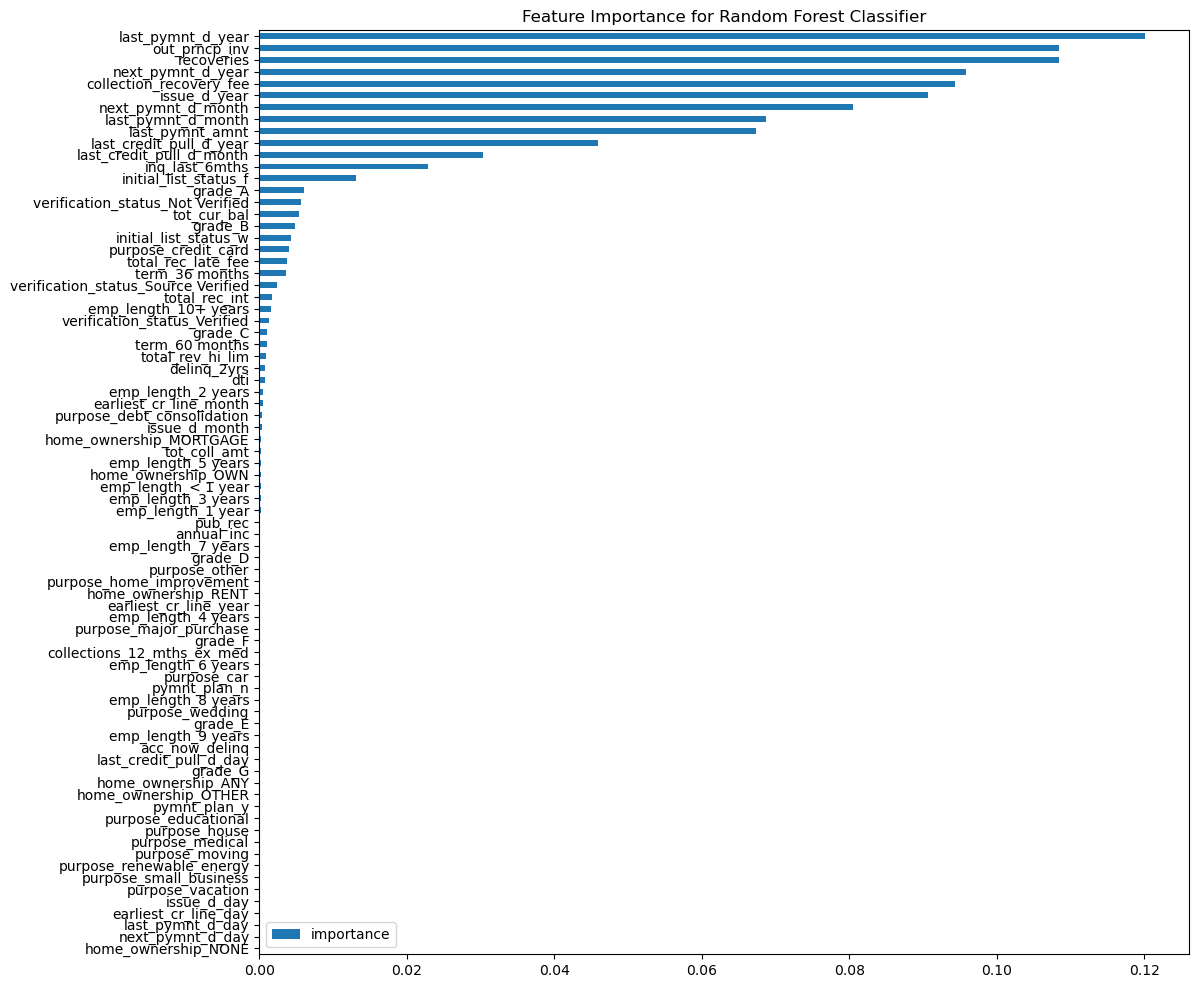

In [96]:
# Plot feature importance
rf_model = model.stages[0] # Get the random forest model from the pipeline
feature_importance = rf_model.featureImportances # Get the feature importance vector
feature_importance_df = pd.DataFrame(feature_importance.toArray(), index=feature_list, columns=["importance"]) # Create a pandas dataframe with feature names and importance values
feature_importance_df.sort_values(by="importance", ascending=True, inplace=True) # Sort the dataframe by importance values
feature_importance_df.plot(kind="barh", figsize=(12, 12)) # Plot the dataframe as a bar chart
plt.title("Feature Importance for Random Forest Classifier") # Add a title to the plot
plt.show() # Show the plot

In [97]:
feature_importance_df_ = feature_importance_df[feature_importance_df.importance > 0.01]
feature_importance_list_df_1per = feature_importance_df_.index.tolist()
feature_importance_list_df_1per

['initial_list_status_f',
 'inq_last_6mths',
 'last_credit_pull_d_month',
 'last_credit_pull_d_year',
 'last_pymnt_amnt',
 'last_pymnt_d_month',
 'next_pymnt_d_month',
 'issue_d_year',
 'collection_recovery_fee',
 'next_pymnt_d_year',
 'recoveries',
 'out_prncp_inv',
 'last_pymnt_d_year']

## Filter Feature Importance

In [98]:
spark_df_cop = spark_df_smote
feature_list = feature_importance_list_df_1per

vec = VectorAssembler(inputCols=feature_list, outputCol = "features")
spark_df_cop = vec.transform(spark_df_cop)

indexer = StringIndexer(inputCol="loan_status", outputCol="loan_status_index")
indexer_fit = indexer.fit(spark_df_cop)
spark_df_cop = indexer_fit.transform(spark_df_cop)

train, test = spark_df_cop.randomSplit([0.8, 0.2], seed=42)

rf = RandomForestClassifier(labelCol="loan_status_index", featuresCol="features", numTrees=100)
pipeline = Pipeline(stages=[rf])
model = pipeline.fit(train)

# Make predictions
predictions = model.transform(test)

# Evaluate model
evaluator = MulticlassClassificationEvaluator(labelCol="loan_status_index", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Accuracy = %g" % accuracy)

23/07/02 12:33:17 WARN TaskSetManager: Stage 20 contains a task of very large size (137294 KiB). The maximum recommended task size is 1000 KiB.
23/07/02 12:33:32 WARN TaskSetManager: Stage 23 contains a task of very large size (137294 KiB). The maximum recommended task size is 1000 KiB.
23/07/02 12:33:41 WARN TaskSetManager: Stage 24 contains a task of very large size (137294 KiB). The maximum recommended task size is 1000 KiB.
23/07/02 12:34:06 WARN TaskSetManager: Stage 25 contains a task of very large size (137294 KiB). The maximum recommended task size is 1000 KiB.
23/07/02 12:34:27 WARN TaskSetManager: Stage 27 contains a task of very large size (137294 KiB). The maximum recommended task size is 1000 KiB.
23/07/02 12:35:07 WARN TaskSetManager: Stage 29 contains a task of very large size (137294 KiB). The maximum recommended task size is 1000 KiB.
23/07/02 12:35:21 WARN TaskSetManager: Stage 31 contains a task of very large size (137294 KiB). The maximum recommended task size is 10

Test Accuracy = 0.799784


In [99]:
# Generate classification report
labels = indexer_fit.labels # Get the label names from the indexer
predictions_df = predictions.select("loan_status_index", "prediction").toPandas() # Convert predictions to pandas dataframe
report_df = pd.crosstab(predictions_df["loan_status_index"], predictions_df["prediction"], rownames=["Actual"], colnames=["Predicted"]) # Create a confusion matrix
my_dict = {i: indexer_fit.labels[i] for i in range(len(indexer_fit.labels))}
print(my_dict)
print()
#report_df.index = labels # Replace the numeric indices with label names
#report_df.columns = labels # Replace the numeric indices with label names
print(report_df) # Print the classification report

23/07/02 12:36:51 WARN TaskSetManager: Stage 39 contains a task of very large size (137294 KiB). The maximum recommended task size is 1000 KiB.


{0: 'Charged Off', 1: 'Current', 2: 'Default', 3: 'Does not meet the credit policy. Status:Charged Off', 4: 'Does not meet the credit policy. Status:Fully Paid', 5: 'Fully Paid', 6: 'In Grace Period', 7: 'Late (16-30 days)', 8: 'Late (31-120 days)'}

Predicted    0.0    1.0    2.0    3.0    4.0    5.0    6.0    7.0    8.0
Actual                                                                  
0.0        34208      0      0      0      0  10675      0      0      0
1.0            0  34913      0      0      0      9   7769   2265      0
2.0            0      6  39450      0      0      0     47      0   5307
3.0            0      0      0  43871    867      0      0      0      0
4.0            0      0      0    328  44713      2      0      0      0
5.0           17      0      0      0      0  44822      0      0      0
6.0            0   3360  10507      0      0      2  25593    702   4600
7.0            0    275   2615      0      0      0  18752  17535   5705
8.0            0   

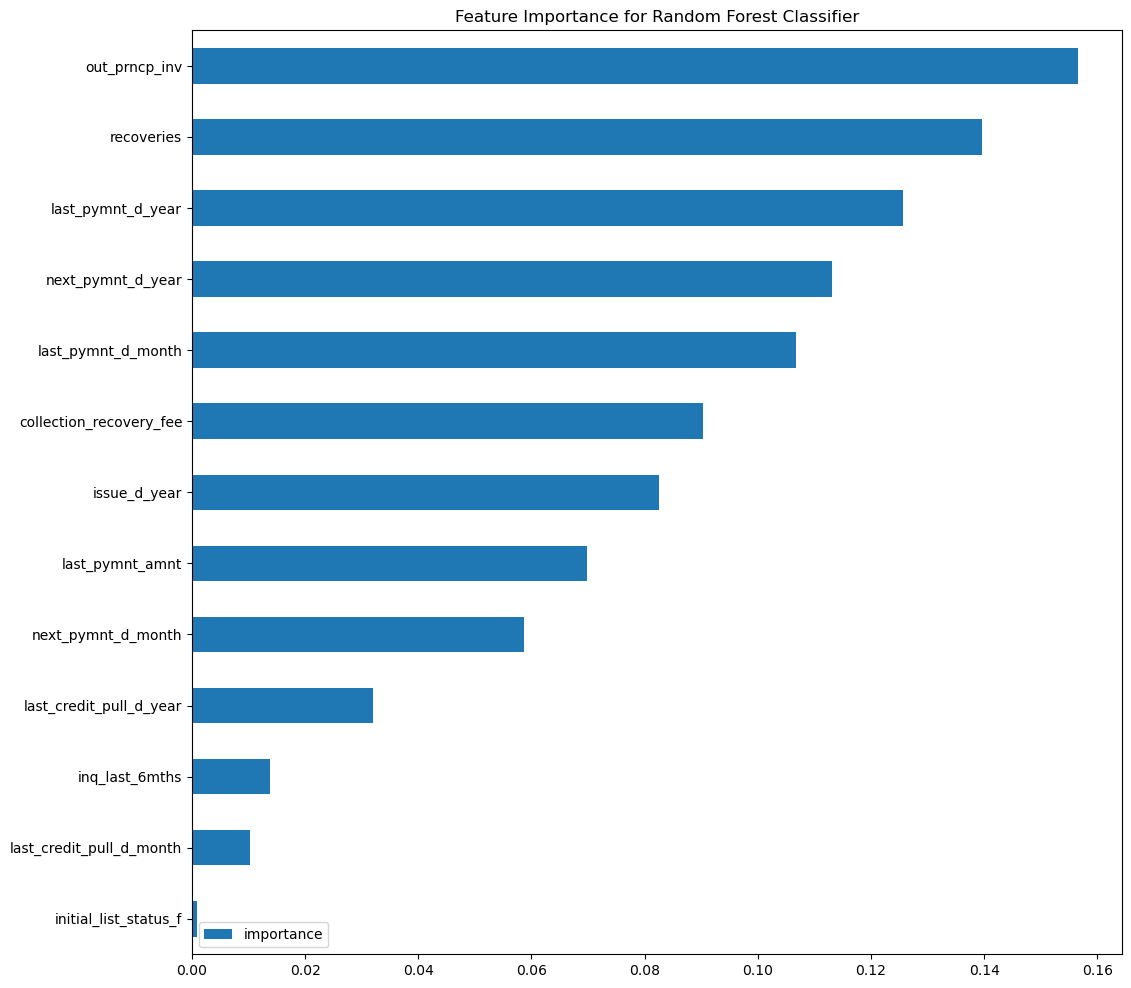

In [100]:
# Plot feature importance
rf_model = model.stages[0] # Get the random forest model from the pipeline
feature_importance = rf_model.featureImportances # Get the feature importance vector
feature_importance_df = pd.DataFrame(feature_importance.toArray(), index=feature_list, columns=["importance"]) # Create a pandas dataframe with feature names and importance values
feature_importance_df.sort_values(by="importance", ascending=True, inplace=True) # Sort the dataframe by importance values
feature_importance_df.plot(kind="barh", figsize=(12, 12)) # Plot the dataframe as a bar chart
plt.title("Feature Importance for Random Forest Classifier") # Add a title to the plot
plt.show() # Show the plot